# Лабораторная работа №2. Задача классификации

**Тема:** *Анализ и сравнение разных классификаторов*

**Цели:**

- *Научиться обрабатывать датасет*
- *Реализовать разные классификаторы*
- *Понять, как интерпретировать важность признаков (feature importance)*
- *Понять, как увеличивать кол-во признаков (feature tuning)*


**Модели:**

- *Логистическая регрессия*
- *Метод опорных векторов (SVM)*
- *$K$ - ближайших соседей*
- *Дерево решений*
- *Случайный лес*
- *Градиентный бустинг*


#### 👋🏻 ЧТО НУЖНО СДЕЛАТЬ СТУДЕНТАМ ???

1. Загрузить датасет, который был в `lr_1.ipynb`
2. Свести его к задаче классификации (бинарной или многоклассовой).
3. Обработать датасет
4. Обучить модели
5. (команда) Реализовать свою логистическую регрессию. Настроить параметр вероятности ответа как if $y_{pred} > 0.5$ then $1$ else $0$
6. **(необезательно, но можно получить плюсик от меня)** С помощью `optuna` реализовать подгонку гиперпараметров моделей
7. Ответить на вопросы
8. Придумать какую-то уникальность работы, то, что будет вас отличать от других, и это вам надо будет мне "продать"
8. Составить `презентацию` о проделанной работе (10-15 слайдов), а именно: нужно выбрать одну модель, и для нее сделать полный анализ
9. Записать `видео вашей защиты на 5 минут`, где вы рассказываете только о вашей фиче.

#### Форматы сдачи

1. Один студент, делает только стандартные реализации. Упрощенная форма сдачи.
2. Команда из 2х людей. Нужно обязательно сделать Логистическую регрессию и сравнить ее с лучшей стандартной реализацией.
3. Команда из 3х людей. Сделать то, что и в команде из 2х человек + обязательно реализация подбора гиперпараметров с помощью optuna

#### Как получить дополнительные плюсики

Я буду оценивать вашу работу комплексно, т.к. нас `55 человек`, то:
1. Самую лучшую работу, сданную на 5, буду расценивать за 6 плюсиков. Если вы в соло делаете, это большое преимущество для вас.
2. 5 человек получат по 2 плюсика
3. 10 человек получат по 1 плюсику

#### Дедлайны

- До 24.10.25 argmax(оценки) = 5 (есть возможность на +)
- До 31.10.25 argmax(оценки) = 4 (нет возможности на +)
- До 07.11.25 argmax(оценки) = 3 (нет возможности на +)

## 1. Введение

Цель: загрузить датасет, сделать описание и сформулировать задачу

### 1.0. Импортируем библиотеки и зафиксируем случайность

In [ ]:
# Main libs for data
from google.colab import drive
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Для обработки данных
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Для моделирования и оценки
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    roc_auc_score, roc_curve, auc, classification_report
)

# Модели классификации
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

In [ ]:
# Project Settings
RANDOM_STATE = 42

### 1.1. Загрузка датасета

In [ ]:
# mount gDrive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Путь к файлу датасета
file_path = Path('/content/drive/MyDrive/student_habits_performance.csv')

# Если файл на не на вашем Google Drive, можно загрузить его с вашего компьютера
# Для этого раскомментируйте следующий код:
# from google.colab import files
# uploaded = files.upload()
# file_path = next(iter(uploaded))

In [ ]:
# Загрузка датасета
df_raw = pd.read_csv(file_path)
df_raw.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


In [ ]:
# Удаляем столбец student_id, так как он не содержит полезной информации для анализа
if 'student_id' in df_raw.columns:
    df_raw = df_raw.drop(columns=['student_id'])
df_raw.head()

,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


### 1.2. Описание датасета

Датасет "Student Habits & Performance" содержит информацию о привычках студентов и их влиянии на академическую успеваемость. В датасете представлены следующие категории данных:

- Демографические данные (возраст, пол)
- Академические привычки (часы учебы, посещаемость)
- Личные привычки (использование соцсетей, сон, питание)
- Социально-экономические факторы (образование родителей, качество интернета)
- Показатели здоровья (физическая активность, психическое здоровье)

**Целевая переменная:** exam_score (экзаменационный балл, от 18.4 до 100.0)

Для задачи классификации нам нужно преобразовать эту непрерывную переменную в категориальную.

In [ ]:
# Получим информацию о датасете
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            1000 non-null   int64  
 1   gender                         1000 non-null   object 
 2   study_hours_per_day            1000 non-null   float64
 3   social_media_hours             1000 non-null   float64
 4   netflix_hours                  1000 non-null   float64
 5   part_time_job                  1000 non-null   object 
 6   attendance_percentage          1000 non-null   float64
 7   sleep_hours                    1000 non-null   float64
 8   diet_quality                   1000 non-null   object 
 9   exercise_frequency             1000 non-null   int64  
 10  parental_education_level       909 non-null    object 
 11  internet_quality               1000 non-null   object 
 12  mental_health_rating           1000 non-null   in

In [ ]:
# Статистика по числовым признакам
df_raw.describe()

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,exercise_frequency,mental_health_rating,exam_score
count,1000.0000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.4980,3.55010,2.505500,1.819700,84.131700,6.470100,3.042000,5.438000,69.601500
std,2.3081,1.46889,1.172422,1.075118,9.399246,1.226377,2.025423,2.847501,16.888564
min,17.0000,0.00000,0.000000,0.000000,56.000000,3.200000,0.000000,1.000000,18.400000
25%,18.7500,2.60000,1.700000,1.000000,78.000000,5.600000,1.000000,3.000000,58.475000
50%,20.0000,3.50000,2.500000,1.800000,84.400000,6.500000,3.000000,5.000000,70.500000
75%,23.0000,4.50000,3.300000,2.525000,91.025000,7.300000,5.000000,8.000000,81.325000
max,24.0000,8.30000,7.200000,5.400000,100.000000,10.000000,6.000000,10.000000,100.000000


In [ ]:
# Проверка на пропуски данных
print("Пропуски данных:")
print(df_raw.isna().sum())

Пропуски данных:
age                               0
gender                            0
study_hours_per_day               0
social_media_hours                0
netflix_hours                     0
part_time_job                     0
attendance_percentage             0
sleep_hours                       0
diet_quality                      0
exercise_frequency                0
parental_education_level         91
internet_quality                  0
mental_health_rating              0
extracurricular_participation     0
exam_score                        0
dtype: int64


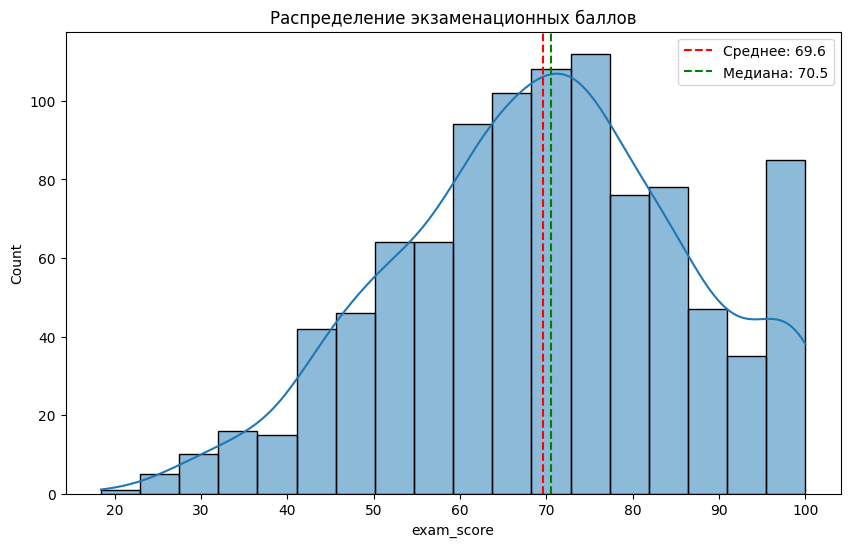

In [ ]:
# Распределение целевой переменной
plt.figure(figsize=(10, 6))
sns.histplot(data=df_raw, x='exam_score', kde=True)
plt.title('Распределение экзаменационных баллов')
plt.axvline(df_raw['exam_score'].mean(), color='r', linestyle='--', label=f'Среднее: {df_raw["exam_score"].mean():.1f}')
plt.axvline(df_raw['exam_score'].median(), color='g', linestyle='--', label=f'Медиана: {df_raw["exam_score"].median():.1f}')
plt.legend()
plt.show()

### 1.3. Постановка задачи классификации

Для преобразования задачи регрессии в задачу классификации будем классифицировать студентов по уровню успеваемости на основе их экзаменационных баллов. Рассмотрим два подхода:

1. **Бинарная классификация**: делим студентов на "успешных" (высокие баллы) и "неуспешных" (низкие баллы)
2. **Многоклассовая классификация**: делим студентов на 3-4 категории по уровню успеваемости

Для начала реализуем бинарную классификацию, используя медиану как пороговое значение.

In [ ]:
# Создаем копию исходного датасета для работы
df = df_raw.copy()

# Вариант 1: Бинарная классификация по медиане
median_score = df['exam_score'].median()
print(f"Медианный балл: {median_score}")
df['high_performance'] = (df['exam_score'] >= median_score).astype(int)

# Проверим распределение классов
print("\nРаспределение классов (бинарная классификация):")
print(df['high_performance'].value_counts())
print(df['high_performance'].value_counts(normalize=True).round(2))

Медианный балл: 70.5

Распределение классов (бинарная классификация):
high_performance
1    501
0    499
Name: count, dtype: int64
high_performance
1    0.5
0    0.5
Name: proportion, dtype: float64


In [ ]:
# Вариант 2: Многоклассовая классификация
# Разделим на 3 категории: низкий, средний и высокий уровень

# Определим границы для категорий (используем квантили для равномерного распределения)
low_threshold = df['exam_score'].quantile(0.33)
high_threshold = df['exam_score'].quantile(0.67)

print(f"Пороги для категорий: низкий < {low_threshold:.1f} <= средний < {high_threshold:.1f} <= высокий")

# Создадим новую колонку для многоклассовой задачи
def categorize_score(score):
    if score < low_threshold:
        return 0  # низкий уровень
    elif score < high_threshold:
        return 1  # средний уровень
    else:
        return 2  # высокий уровень

df['performance_category'] = df['exam_score'].apply(categorize_score)

# Проверим распределение классов
print("\nРаспределение классов (многоклассовая классификация):")
print(df['performance_category'].value_counts())
print(df['performance_category'].value_counts(normalize=True).round(2))

Пороги для категорий: низкий < 62.7 <= средний < 77.0 <= высокий

Распределение классов (многоклассовая классификация):
performance_category
1    341
2    330
0    329
Name: count, dtype: int64
performance_category
1    0.34
2    0.33
0    0.33
Name: proportion, dtype: float64


Для этой лабораторной работы будем использовать бинарную классификацию как основную задачу, так как она проще для интерпретации результатов, но также покажем некоторые результаты для многоклассовой классификации.

## 2. Подготовка данных

### 2.1. Анализ и обработка признаков

In [ ]:
# Разделим признаки на числовые и категориальные
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Удалим целевые переменные из списков признаков
if 'exam_score' in numerical_cols:
    numerical_cols.remove('exam_score')
if 'high_performance' in numerical_cols:
    numerical_cols.remove('high_performance')
if 'performance_category' in numerical_cols:
    numerical_cols.remove('performance_category')

print("Категориальные признаки:")
print(categorical_cols)
print("\nЧисловые признаки:")
print(numerical_cols)

Категориальные признаки:
['gender', 'part_time_job', 'diet_quality', 'parental_education_level', 'internet_quality', 'extracurricular_participation']

Числовые признаки:
['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours', 'attendance_percentage', 'sleep_hours', 'exercise_frequency', 'mental_health_rating']


In [ ]:
# Проверим уникальные значения категориальных признаков
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")
    print(f"Количество уникальных значений: {df[col].nunique()}")
    print("---")

gender: ['Female' 'Male' 'Other']
Количество уникальных значений: 3
---
part_time_job: ['No' 'Yes']
Количество уникальных значений: 2
---
diet_quality: ['Fair' 'Good' 'Poor']
Количество уникальных значений: 3
---
parental_education_level: ['Master' 'High School' 'Bachelor' nan]
Количество уникальных значений: 3
---
internet_quality: ['Average' 'Poor' 'Good']
Количество уникальных значений: 3
---
extracurricular_participation: ['Yes' 'No']
Количество уникальных значений: 2
---


In [ ]:
# Обработаем пропуски в parental_education_level
print(f"Пропуски в parental_education_level: {df['parental_education_level'].isna().sum()}")
print(f"Процент пропусков: {df['parental_education_level'].isna().mean() * 100:.1f}%")

# Заполним пропуски значением 'None' (отсутствие данных об образовании)
df['parental_education_level'] = df['parental_education_level'].fillna('None')

Пропуски в parental_education_level: 91
Процент пропусков: 9.1%


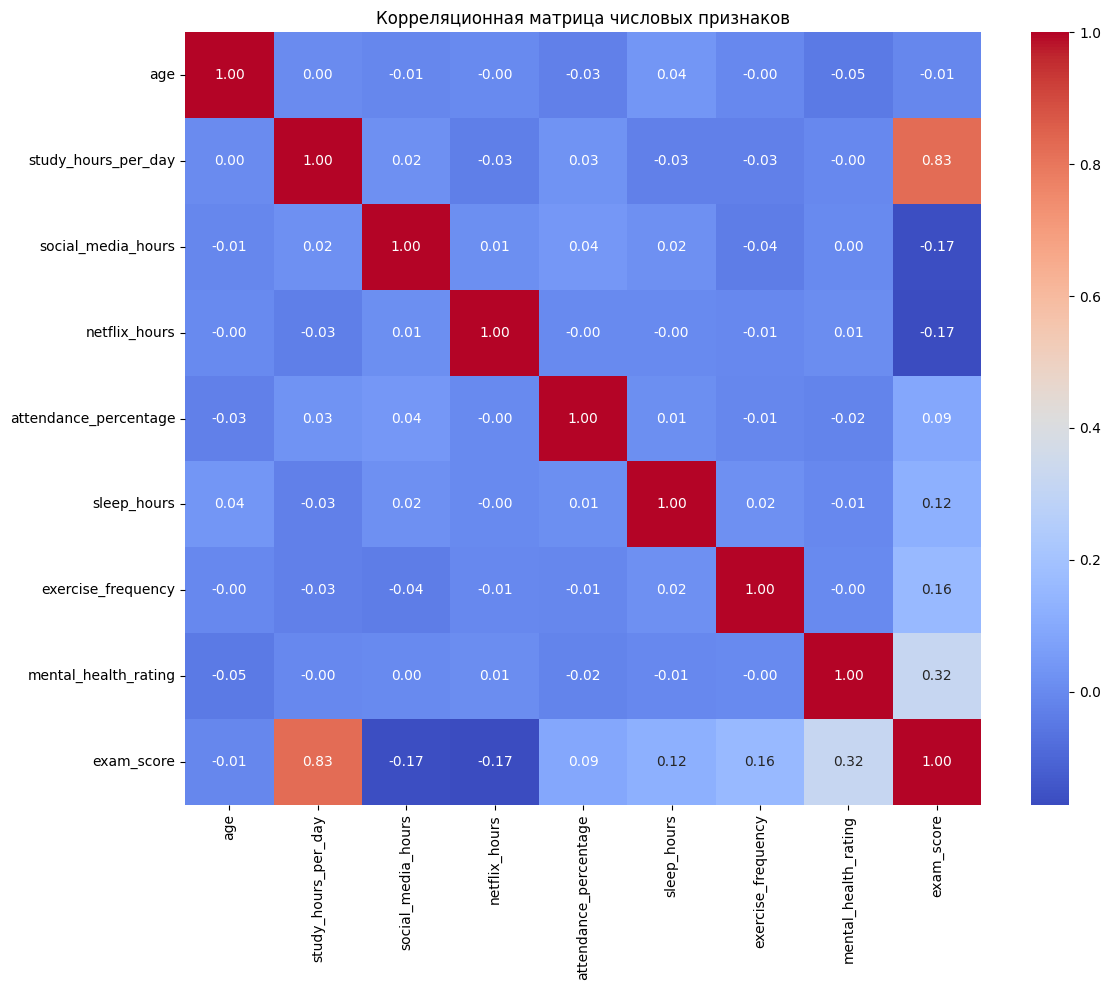

In [ ]:
# Корреляция между числовыми признаками и целевой переменной
corr_matrix = df[numerical_cols + ['exam_score']].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица числовых признаков')
plt.tight_layout()
plt.show()

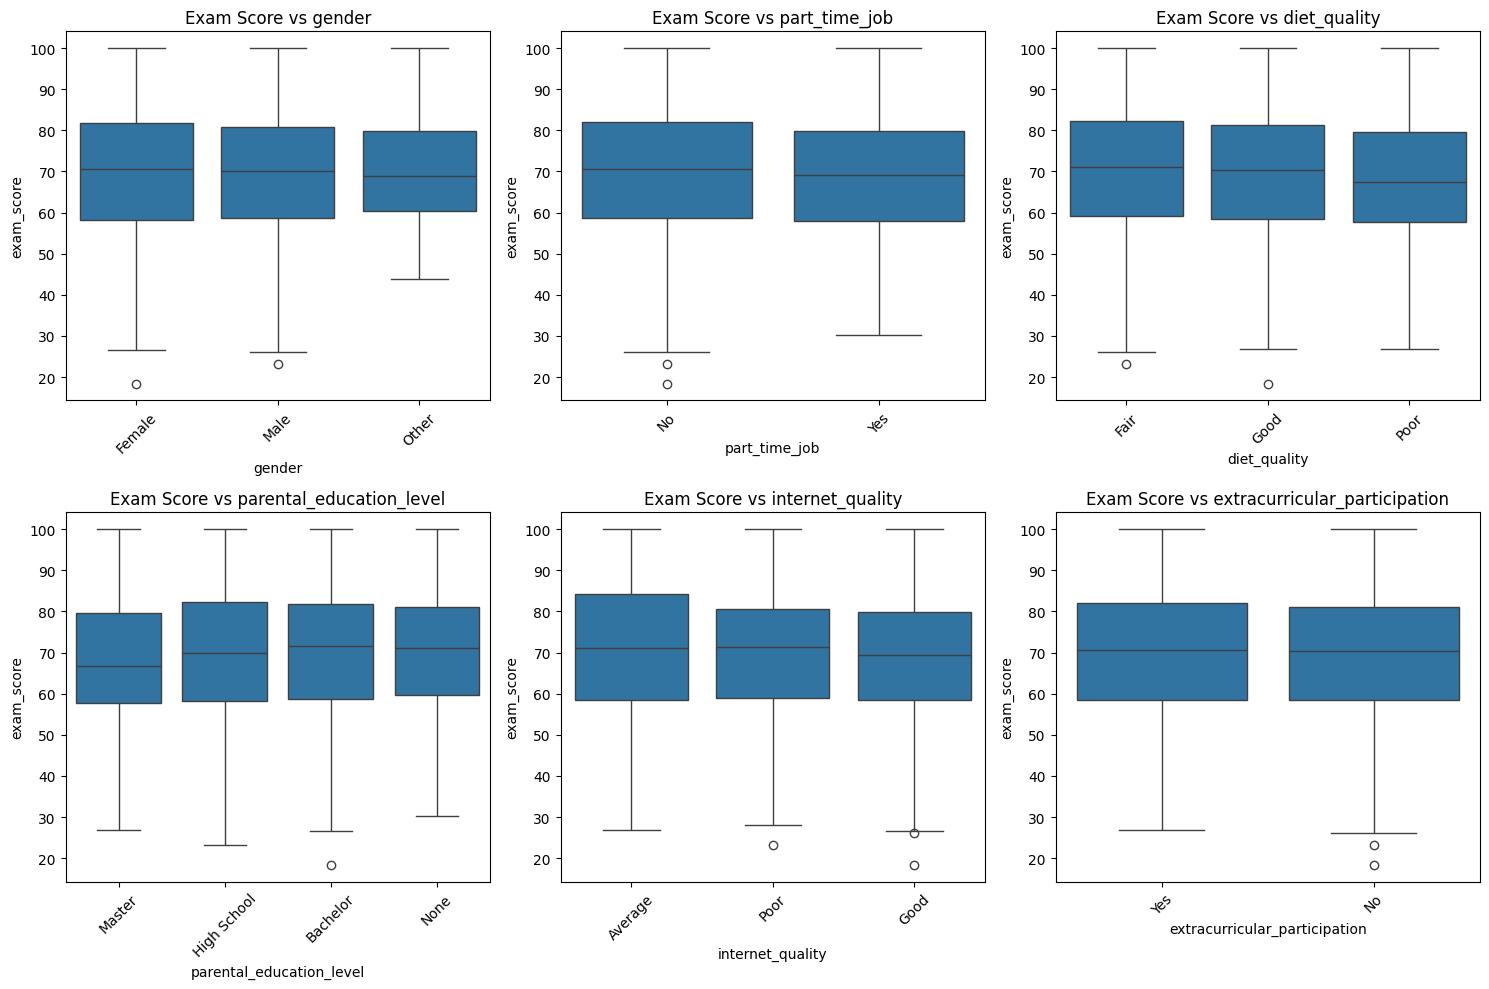

In [ ]:
# Визуализируем зависимость между категориальными признаками и целевой переменной
plt.figure(figsize=(15, 10))

for i, col in enumerate(categorical_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data=df, x=col, y='exam_score')
    plt.xticks(rotation=45)
    plt.title(f'Exam Score vs {col}')
    plt.tight_layout()

plt.show()

Средний балл студентов 'группы риска' vs остальных:
                      mean  median        std
at_risk_student                              
0                69.666839    70.6  16.958917
1                67.800000    67.5  14.920949


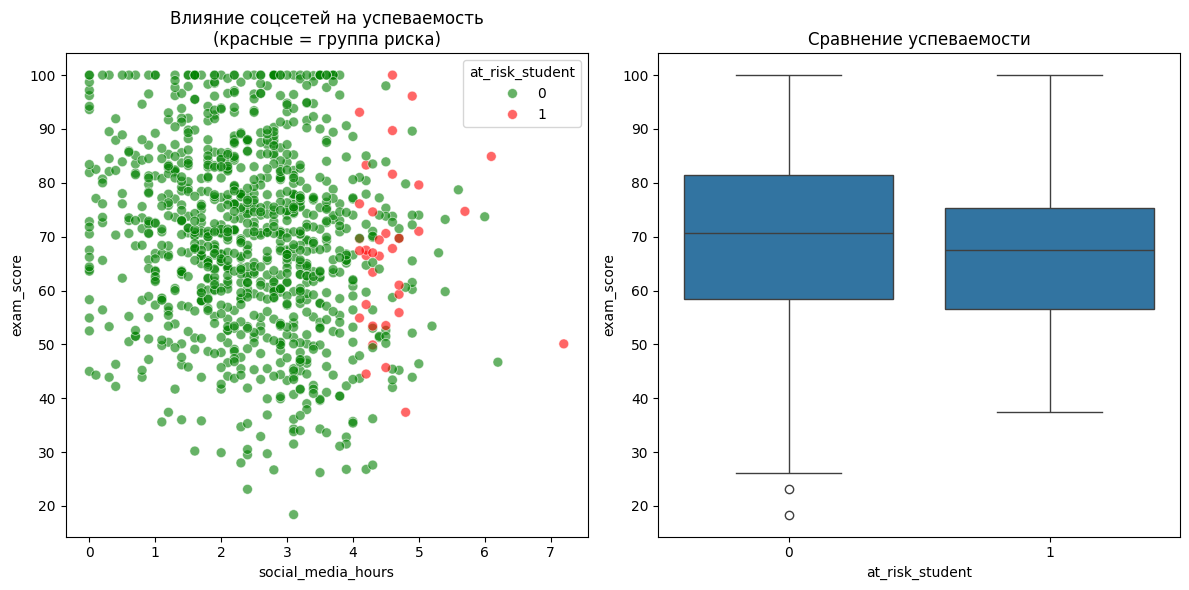


t-test: t=-0.6422, p-value=0.5209


In [ ]:
# Гипотеза: Студенты, которые мало спят И много сидят в соцсетях,
# имеют значительно худшую успеваемость

# Создаём новый признак: interaction между social_media_hours и sleep_hours
df['sleep_social_interaction'] = df['sleep_hours'] * (24 - df['social_media_hours'])

# Или бинарный признак: "группа риска"
df['at_risk_student'] = ((df['sleep_hours'] < 6) & (df['social_media_hours'] > 4)).astype(int)

# Анализ гипотезы
print("Средний балл студентов 'группы риска' vs остальных:")
print(df.groupby('at_risk_student')['exam_score'].agg(['mean', 'median', 'std']))

# Визуализация
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='social_media_hours', y='exam_score',
                hue='at_risk_student', palette=['green', 'red'], s=50, alpha=0.6)
plt.title('Влияние соцсетей на успеваемость\n(красные = группа риска)')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='at_risk_student', y='exam_score')
plt.title('Сравнение успеваемости')
plt.tight_layout()
plt.show()

# t-test для проверки статистической значимости
from scipy import stats
risk_group = df[df['at_risk_student'] == 1]['exam_score']
normal_group = df[df['at_risk_student'] == 0]['exam_score']
t_stat, p_value = stats.ttest_ind(risk_group, normal_group)
print(f"\nt-test: t={t_stat:.4f}, p-value={p_value:.4f}")
if p_value < 0.05:
    print("✅ Гипотеза подтверждена статистически! (p < 0.05)")


### 2.2. Разделение на обучающую и тестовую выборки

In [ ]:
# Определим признаки и целевую переменную для бинарной классификации
X = df.drop(['exam_score', 'high_performance', 'performance_category'], axis=1)
y_binary = df['high_performance']
y_multi = df['performance_category']

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train_binary, y_test_binary = train_test_split(
    X, y_binary, test_size=0.2, random_state=RANDOM_STATE, stratify=y_binary
)

# Также разделим для многоклассовой классификации
_, _, y_train_multi, y_test_multi = train_test_split(
    X, y_multi, test_size=0.2, random_state=RANDOM_STATE, stratify=y_multi
)

print(f"Обучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")

Обучающая выборка: (800, 16)
Тестовая выборка: (200, 16)


### 2.3. Создание пайплайна предобработки

In [ ]:
# Создадим пайплайн предобработки данных
# Для числовых признаков: заполнение пропусков и стандартизация
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Для категориальных признаков: заполнение пропусков и one-hot кодирование
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Объединяем трансформеры в препроцессор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Применяем препроцессор к обучающей выборке
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Получим названия признаков после one-hot кодирования
# для лучшей интерпретации результатов
cat_cols_after_transform = []
for i, col in enumerate(categorical_cols):
    categories = preprocessor.transformers_[1][1].named_steps['onehot'].categories_[i]
    cat_cols_after_transform.extend([f"{col}_{cat}" for cat in categories])

all_features = numerical_cols + cat_cols_after_transform

print(f"Количество признаков после преобразования: {X_train_processed.shape[1]}")
print(f"Пример преобразованных признаков: {all_features[:5]}...")

Количество признаков после преобразования: 25
Пример преобразованных признаков: ['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours', 'attendance_percentage']...


In [ ]:
# 1. Индекс здорового образа жизни
df['health_index'] = (
    df['sleep_hours'] / 8 +  # нормализация сна (8 часов = 1.0)
    df['mental_health_rating'] / 10 +
    (24 - df['social_media_hours']) / 20  # меньше соцсетей = лучше
) / 3

# 2. Академический индекс
df['academic_index'] = (
    df['study_hours_per_day'] / 5 +  # 5 часов учебы = 1.0
    df['attendance_percentage'] / 100 +
    df['exercise_frequency'] / 6
) / 3

# 3. Баланс учёба-отдых
df['study_leisure_ratio'] = df['study_hours_per_day'] / (df['social_media_hours'] + 1)

# 4. Интенсивность учёбы с учётом посещаемости
df['effective_study'] = df['study_hours_per_day'] * (df['attendance_percentage'] / 100)

# 5. Полиномиальные признаки для ключевых переменных
df['study_squared'] = df['study_hours_per_day'] ** 2
df['sleep_squared'] = df['sleep_hours'] ** 2

# Оценка важности новых признаков
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif

# Обучаем модель с новыми признаками
new_features = ['health_index', 'academic_index', 'study_leisure_ratio',
                'effective_study', 'study_squared', 'sleep_squared']

print("Важность новых признаков (Mutual Information):")
mi_scores = mutual_info_classif(df[new_features], y_binary)
for feature, score in zip(new_features, mi_scores):
    print(f"  {feature:25s}: {score:.4f}")


Важность новых признаков (Mutual Information):
  health_index             : 0.0517
  academic_index           : 0.1694
  study_leisure_ratio      : 0.2098
  effective_study          : 0.2712
  study_squared            : 0.2491
  sleep_squared            : 0.0123


## 3. Построение и оценка моделей классификации

### 3.1. Пайплайн для оценки моделей

In [ ]:
def test_models_pipeline(X, y, models_dict, n_splits=5, random_state=42):
    """
    Тестирует модели с использованием кросс-валидации и визуализирует результаты

    Parameters:
    -----------
    X : array-like
        Признаки для обучения и тестирования
    y : array-like
        Целевая переменная
    models_dict : dict
        Словарь моделей {имя_модели: модель}
    n_splits : int, default=5
        Количество фолдов для кросс-валидации
    random_state : int, default=42
        Случайное состояние для воспроизводимости
    """
    # Убеждаемся, что X и y - это numpy массивы
    X_array = np.array(X)
    y_array = np.array(y)

    # Создаем объект для стратифицированной кросс-валидации
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Словарь для хранения результатов
    results = {}

    # Для каждой модели
    for name, model in models_dict.items():
        print(f"\n=== {name} ===")

        # Списки для хранения метрик
        acc_list, f1_list, roc_list = [], [], []
        conf_matrices = []

        # Сохраняем последние предсказания для визуализации
        last_y_test = None
        last_y_pred = None
        last_y_proba = None

        # Выполняем кросс-валидацию
        for train_idx, test_idx in kf.split(X_array, y_array):
            X_train_fold, X_test_fold = X_array[train_idx], X_array[test_idx]
            y_train_fold, y_test_fold = y_array[train_idx], y_array[test_idx]

            # Обучение модели
            model.fit(X_train_fold, y_train_fold)

            # Предсказания
            y_pred = model.predict(X_test_fold)

            # Вероятности для ROC-AUC, если доступны
            y_proba = None
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test_fold)[:, 1]
            elif hasattr(model, "decision_function"):
                y_proba = model.decision_function(X_test_fold)

            # Расчет метрик
            acc_list.append(accuracy_score(y_test_fold, y_pred))
            f1_list.append(f1_score(y_test_fold, y_pred))
            if y_proba is not None:
                roc_list.append(roc_auc_score(y_test_fold, y_proba))

            # Сохраняем confusion matrix
            conf_matrices.append(confusion_matrix(y_test_fold, y_pred))

            # Сохраняем данные последнего фолда для визуализации
            last_y_test = y_test_fold
            last_y_pred = y_pred
            last_y_proba = y_proba

        # Вывод средних метрик
        print(f"Accuracy: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}")
        print(f"F1-score: {np.mean(f1_list):.3f} ± {np.std(f1_list):.3f}")
        if roc_list:
            print(f"ROC-AUC: {np.mean(roc_list):.3f} ± {np.std(roc_list):.3f}")

        # Сохраняем результаты
        results[name] = {
            'accuracy_mean': np.mean(acc_list),
            'accuracy_std': np.std(acc_list),
            'f1_mean': np.mean(f1_list),
            'f1_std': np.std(f1_list),
            'roc_auc_mean': np.mean(roc_list) if roc_list else None,
            'roc_auc_std': np.std(roc_list) if roc_list else None
        }

        # Визуализация матрицы ошибок (усредненной по всем фолдам)
        avg_conf_matrix = np.mean(conf_matrices, axis=0).astype(int)
        plt.figure(figsize=(6, 5))
        sns.heatmap(avg_conf_matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Predicted 0', 'Predicted 1'],
                    yticklabels=['Actual 0', 'Actual 1'])
        plt.title(f'Confusion Matrix - {name}')
        plt.tight_layout()
        plt.show()

        # Визуализация ROC-кривой (для последнего фолда)
        if last_y_proba is not None:
            fpr, tpr, _ = roc_curve(last_y_test, last_y_proba)
            roc_auc = auc(fpr, tpr)

            plt.figure(figsize=(6, 5))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {name}')
            plt.legend(loc='lower right')
            plt.show()

    # Создаем сводную таблицу результатов
    results_df = pd.DataFrame([
        {
            'Model': name,
            'Accuracy': f"{res['accuracy_mean']:.3f} ± {res['accuracy_std']:.3f}",
            'F1 Score': f"{res['f1_mean']:.3f} ± {res['f1_std']:.3f}",
            'ROC AUC': f"{res['roc_auc_mean']:.3f} ± {res['roc_auc_std']:.3f}" if res['roc_auc_mean'] else "N/A"
        } for name, res in results.items()
    ])

    # Сортировка по точности
    results_df = results_df.sort_values(
        by='Accuracy',
        key=lambda x: pd.to_numeric(x.str.split(' ').str[0]),
        ascending=False
    ).reset_index(drop=True)

    print("\nСводная таблица результатов:")
    display(results_df)

    # Визуализация сравнения моделей по метрикам
    metrics_for_plot = {}
    for name, res in results.items():
        metrics_for_plot[name] = {
            'Accuracy': res['accuracy_mean'],
            'F1 Score': res['f1_mean'],
            'ROC AUC': res['roc_auc_mean'] if res['roc_auc_mean'] else 0
        }

    metrics_df = pd.DataFrame(metrics_for_plot).T.reset_index().rename(columns={'index': 'Model'})

    plt.figure(figsize=(12, 6))
    metrics_melted = pd.melt(metrics_df, id_vars=['Model'], var_name='Metric', value_name='Value')
    sns.barplot(data=metrics_melted, x='Model', y='Value', hue='Metric')
    plt.title('Сравнение моделей по метрикам')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    return results

### 3.2. Логистическая регрессия

In [ ]:
# Создаем модель логистической регрессии
log_reg = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)


### 3.3. Метод опорных векторов (SVM)

In [ ]:
# Создаем модель SVM
svm_model = SVC(random_state=RANDOM_STATE, probability=True)


### 3.4. K-ближайших соседей

In [ ]:
# Создаем модель KNN
knn_model = KNeighborsClassifier(n_neighbors=5)

### 3.5. Дерево решений

In [ ]:
# Создаем модель дерева решений
dt_model = DecisionTreeClassifier(random_state=RANDOM_STATE)


### 3.6. Случайный лес

In [ ]:
# Создаем модель случайного леса
rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)

### 3.7. Градиентный бустинг

In [ ]:
# Создаем модель градиентного бустинга
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE)

### 3.8. XGBoost

In [ ]:
# Создаем модель XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=RANDOM_STATE)

### 3.9. Сравнение моделей

### 3.10. Кросс-валидация моделей

В предыдущих разделах мы оценивали модели на фиксированном разделении данных (train_test_split),
что дало нам возможность детально визуализировать результаты. Однако такой подход может быть чувствителен к
конкретному разделению данных и не всегда отражает реальную обобщающую способность моделей.

Для получения более надежной оценки производительности моделей используем k-fold кросс-валидацию,
которая:
- Тестирует модель на нескольких различных разделениях данных
- Снижает влияние "удачного" разделения
- Дает более реалистичную оценку работы модели на новых данных
- Позволяет оценить стабильность модели через стандартное отклонение метрик

**Примечание:** Метрики при кросс-валидации могут быть немного ниже, чем при одном фиксированном разделении,
что нормально и часто указывает на более объективную оценку.


=== Логистическая регрессия ===
Accuracy: 0.892 ± 0.017
F1-score: 0.892 ± 0.017
ROC-AUC: 0.966 ± 0.006


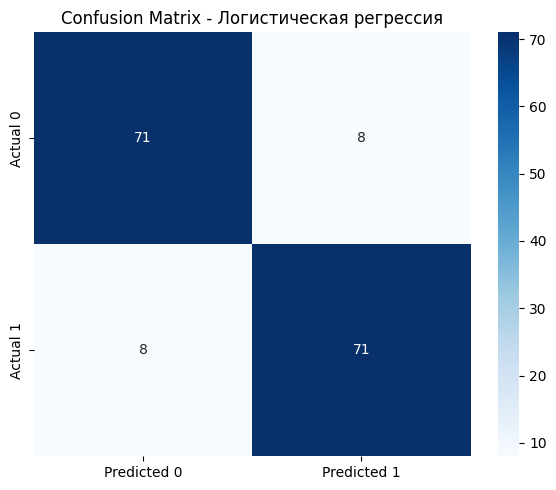

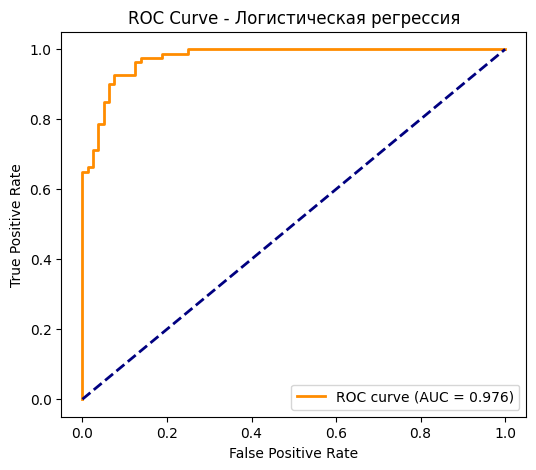


=== SVM ===
Accuracy: 0.875 ± 0.023
F1-score: 0.876 ± 0.023
ROC-AUC: 0.953 ± 0.010


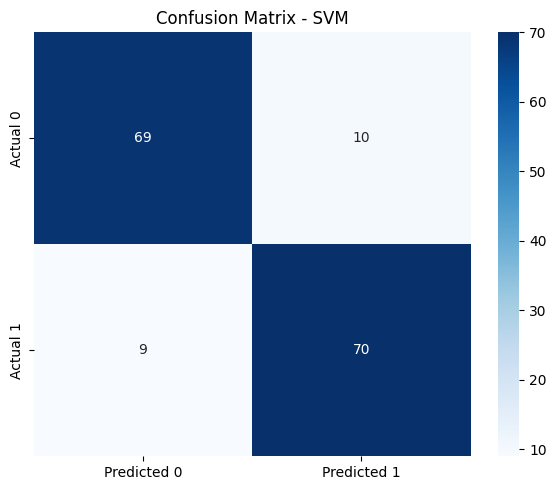

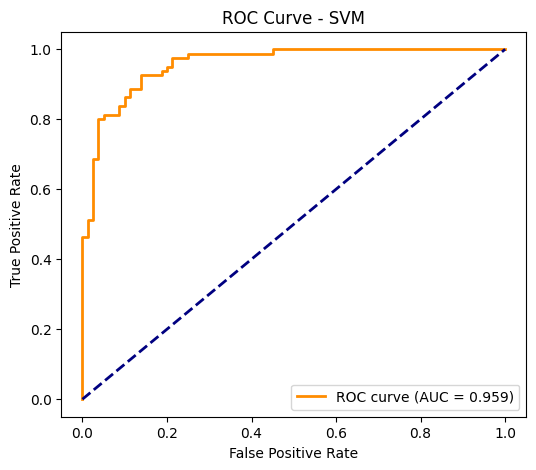


=== KNN ===
Accuracy: 0.784 ± 0.020
F1-score: 0.787 ± 0.020
ROC-AUC: 0.866 ± 0.019


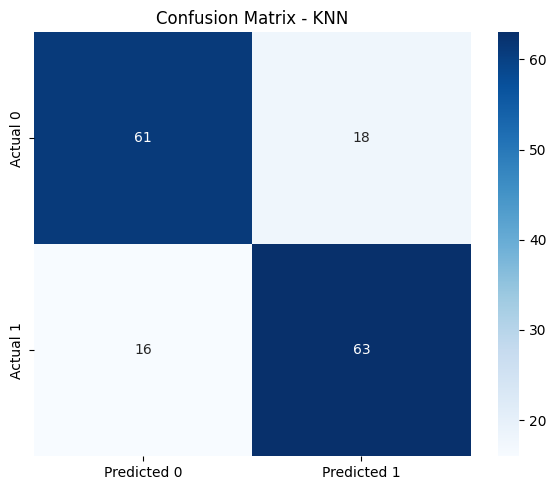

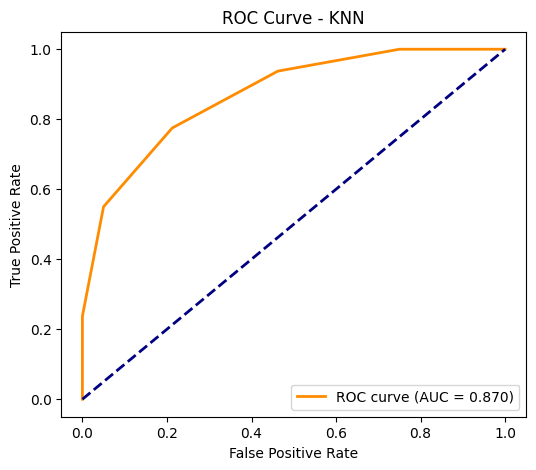


=== Дерево решений ===
Accuracy: 0.812 ± 0.016
F1-score: 0.813 ± 0.018
ROC-AUC: 0.812 ± 0.016


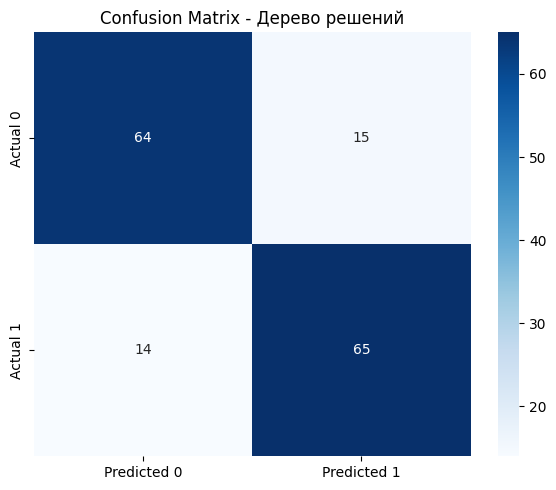

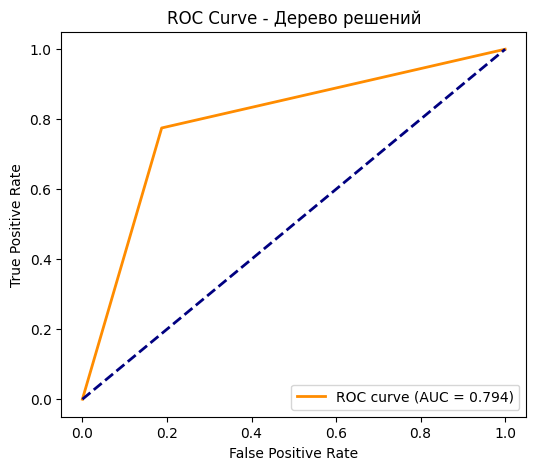


=== Случайный лес ===
Accuracy: 0.858 ± 0.021
F1-score: 0.858 ± 0.023
ROC-AUC: 0.941 ± 0.012


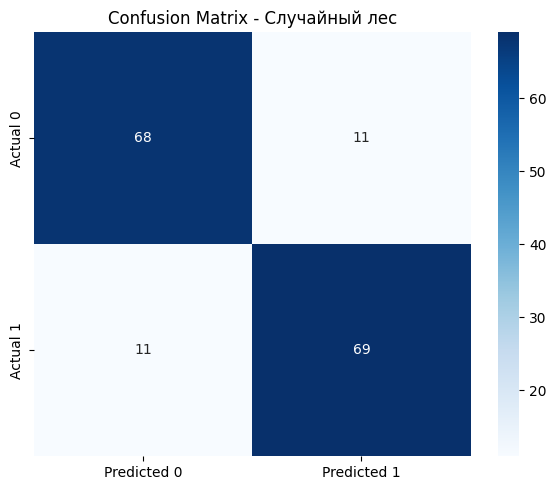

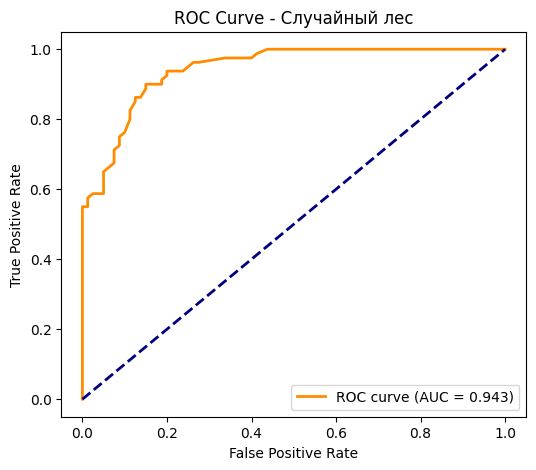


=== Градиентный бустинг ===
Accuracy: 0.859 ± 0.016
F1-score: 0.859 ± 0.016
ROC-AUC: 0.948 ± 0.008


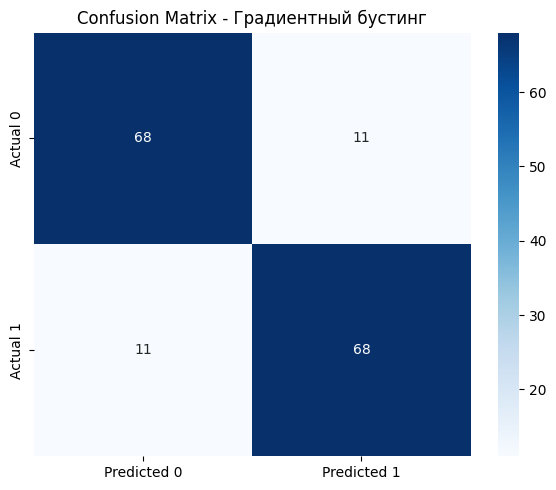

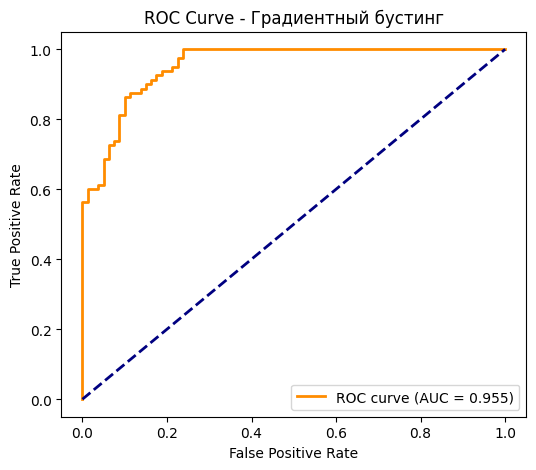


=== XGBoost ===
Accuracy: 0.872 ± 0.010
F1-score: 0.874 ± 0.012
ROC-AUC: 0.947 ± 0.007


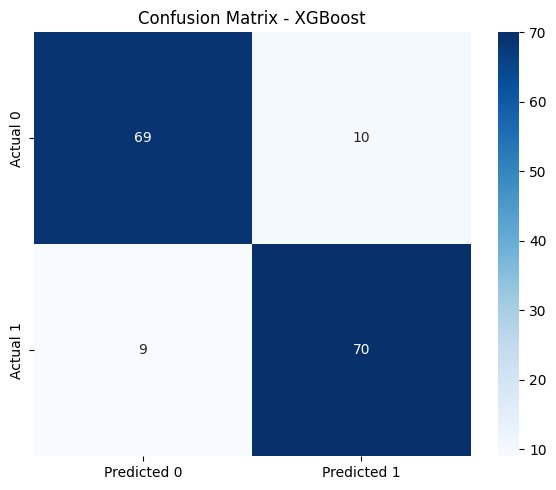

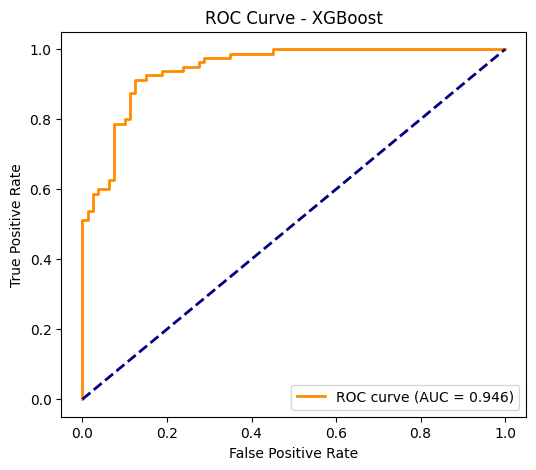


Сводная таблица результатов:


,Model,Accuracy,F1 Score,ROC AUC
0,Логистическая регрессия,0.892 ± 0.017,0.892 ± 0.017,0.966 ± 0.006
1,SVM,0.875 ± 0.023,0.876 ± 0.023,0.953 ± 0.010
2,XGBoost,0.872 ± 0.010,0.874 ± 0.012,0.947 ± 0.007
3,Градиентный бустинг,0.859 ± 0.016,0.859 ± 0.016,0.948 ± 0.008
4,Случайный лес,0.858 ± 0.021,0.858 ± 0.023,0.941 ± 0.012
5,Дерево решений,0.812 ± 0.016,0.813 ± 0.018,0.812 ± 0.016
6,KNN,0.784 ± 0.020,0.787 ± 0.020,0.866 ± 0.019


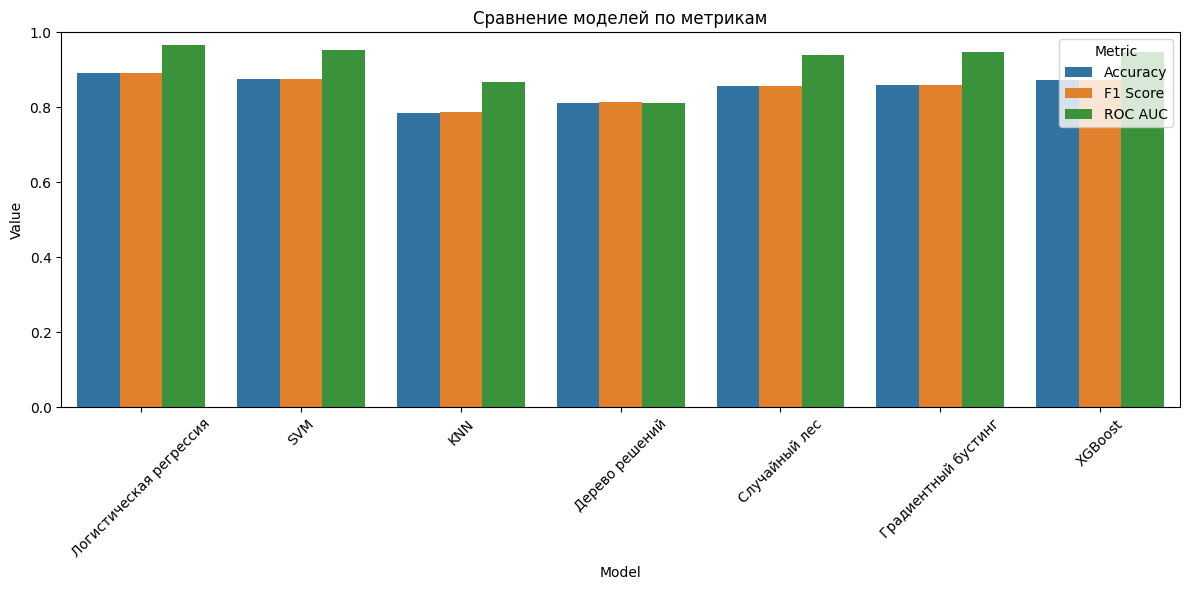

In [ ]:
# Создаем словарь с моделями для тестирования
models_to_test = {
    "Логистическая регрессия": LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    "SVM": SVC(probability=True, random_state=RANDOM_STATE),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Дерево решений": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "Случайный лес": RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    "Градиентный бустинг": GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE),
    "XGBoost": xgb.XGBClassifier(n_estimators=100, random_state=RANDOM_STATE)
}

# Преобразуем данные в numpy массивы, если нужно
X_array = X_train_processed
y_array = np.array(y_train_binary) if hasattr(y_train_binary, 'values') else y_train_binary

# Запускаем тестирование моделей
results = test_models_pipeline(X_array, y_array, models_to_test, n_splits=5)

In [ ]:
# Создаем датафрейм с результатами для более удобного сравнения
cv_results_df = pd.DataFrame([
    {
        'Модель': name,
        'Accuracy': f"{res['accuracy_mean']:.3f} ± {res['accuracy_std']:.3f}",
        'F1 Score': f"{res['f1_mean']:.3f} ± {res['f1_std']:.3f}",
        'ROC AUC': f"{res['roc_auc_mean']:.3f} ± {res['roc_auc_std']:.3f}" if 'roc_auc_mean' in res else "N/A"
    }
    for name, res in results.items()
])

# Создаем также версию с численными значениями для сортировки
cv_results_numeric = pd.DataFrame([
    {
        'Модель': name,
        'Accuracy': res['accuracy_mean'],
        'F1 Score': res['f1_mean'],
        'ROC AUC': res['roc_auc_mean'] if 'roc_auc_mean' in res else np.nan
    }
    for name, res in results.items()
])

# Сортируем по убыванию точности
cv_results_numeric_sorted = cv_results_numeric.sort_values('Accuracy', ascending=False).reset_index(drop=True)

print("Сравнение моделей на основе кросс-валидации:")
display(cv_results_df.sort_values('Accuracy', key=lambda x: pd.to_numeric(x.str.split(' ').str[0]), ascending=False))

Сравнение моделей на основе кросс-валидации:


,Модель,Accuracy,F1 Score,ROC AUC
0,Логистическая регрессия,0.892 ± 0.017,0.892 ± 0.017,0.966 ± 0.006
1,SVM,0.875 ± 0.023,0.876 ± 0.023,0.953 ± 0.010
6,XGBoost,0.872 ± 0.010,0.874 ± 0.012,0.947 ± 0.007
5,Градиентный бустинг,0.859 ± 0.016,0.859 ± 0.016,0.948 ± 0.008
4,Случайный лес,0.858 ± 0.021,0.858 ± 0.023,0.941 ± 0.012
3,Дерево решений,0.812 ± 0.016,0.813 ± 0.018,0.812 ± 0.016
2,KNN,0.784 ± 0.020,0.787 ± 0.020,0.866 ± 0.019


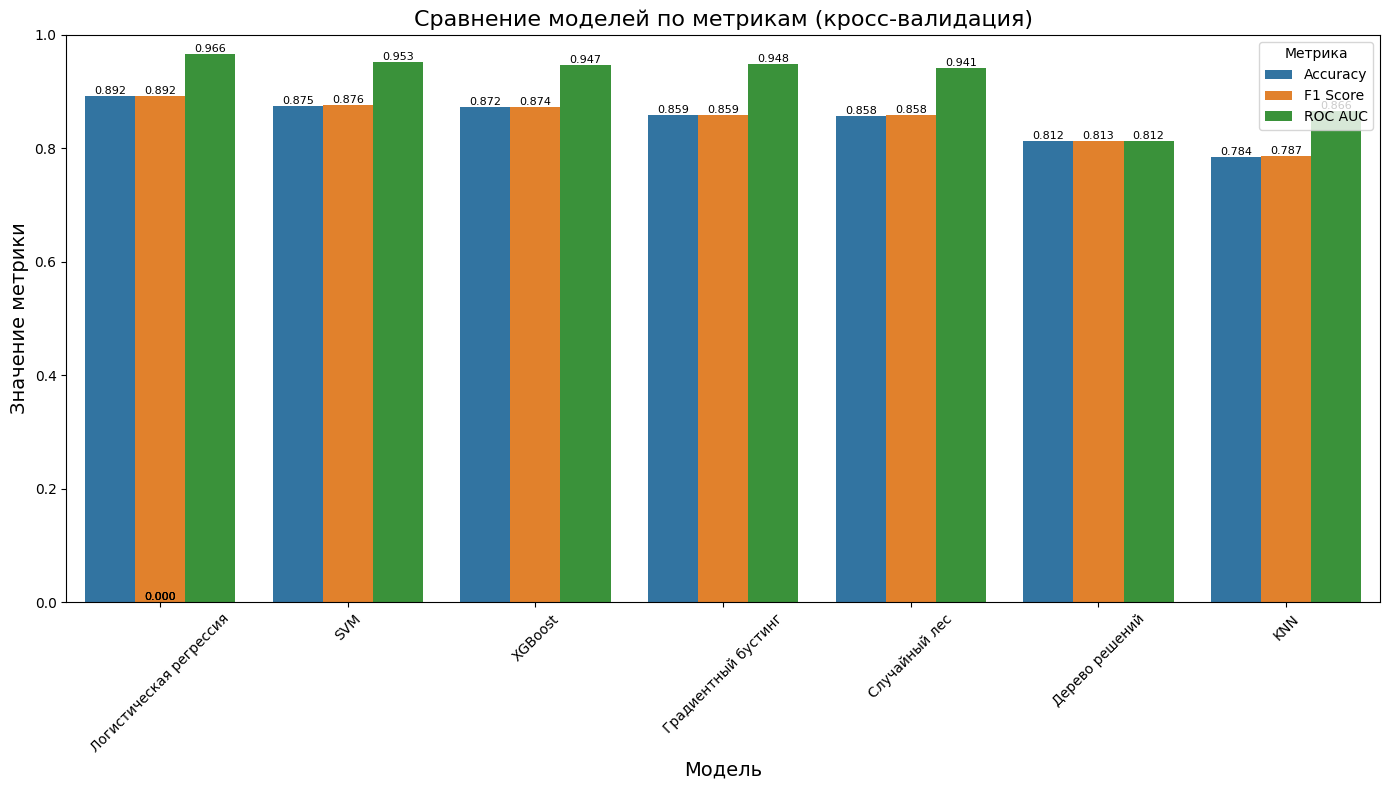

In [ ]:
# Визуализация сравнения моделей
plt.figure(figsize=(14, 8))

# Создаем данные для графика
plot_data = cv_results_numeric_sorted.melt(id_vars='Модель', var_name='Метрика', value_name='Значение')

# Рисуем график
sns.barplot(data=plot_data, x='Модель', y='Значение', hue='Метрика')

# Добавляем подписи
plt.title('Сравнение моделей по метрикам (кросс-валидация)', fontsize=16)
plt.xlabel('Модель', fontsize=14)
plt.ylabel('Значение метрики', fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Добавляем значения метрик над столбцами
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_height():.3f}",
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center', va = 'bottom',
                      fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
def plot_decision_surface_2d(X, y, model, model_name='Model', feature_names=None):
    """
    Визуализация разделяющей поверхности в 2D пространстве с использованием PCA.
    Показывает, какие признаки вносят наибольший вклад в главные компоненты.

    Parameters:
        X : array-like, shape (n_samples, n_features)
            Признаки (уже масштабированные через StandardScaler)
        y : array-like, shape (n_samples,)
            Целевая переменная (бинарная)
        model : sklearn estimator
            Обученная модель классификации
        model_name : str
            Название модели для заголовка графика
        feature_names : list, optional
            Названия признаков для интерпретации компонент
    """
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    import numpy as np

    # Применяем PCA для получения 2D представления
    if X.shape[1] > 2:
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(X)
        explained_var = pca.explained_variance_ratio_

        # Получаем компоненты (веса признаков)
        components = pca.components_

        # Функция для получения топ-3 признаков компоненты
        def get_top_features(component_weights, feature_names, n_top=3):
            if feature_names is None or len(feature_names) != len(component_weights):
                return ""

            # Берем абсолютные значения весов
            abs_weights = np.abs(component_weights)
            top_indices = np.argsort(abs_weights)[::-1][:n_top]

            # Формируем строку с топ признаками
            top_features = []
            for idx in top_indices:
                weight = component_weights[idx]
                sign = '+' if weight > 0 else '-'
                top_features.append(f"{sign}{feature_names[idx]}")

            return ", ".join(top_features)

        # Создаем подписи осей с топ признаками
        pc1_top = get_top_features(components[0], feature_names)
        pc2_top = get_top_features(components[1], feature_names)

        if pc1_top:
            xlabel = f'PC1 ({explained_var[0]:.1%})\nОсновные признаки: {pc1_top}'
        else:
            xlabel = f'PC1 (объясняет {explained_var[0]:.1%} вариации)'

        if pc2_top:
            ylabel = f'PC2 ({explained_var[1]:.1%})\nОсновные признаки: {pc2_top}'
        else:
            ylabel = f'PC2 (объясняет {explained_var[1]:.1%} вариации)'
    else:
        X_2d = X
        if feature_names and len(feature_names) >= 2:
            xlabel = feature_names[0]
            ylabel = feature_names[1]
        else:
            xlabel = 'Признак 1'
            ylabel = 'Признак 2'

    # Обучаем копию модели на 2D данных
    from copy import deepcopy
    model_2d = deepcopy(model)
    model_2d.fit(X_2d, y)

    # Создаем сетку для визуализации
    h = 0.02  # шаг сетки
    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Предсказываем класс для каждой точки сетки
    Z = model_2d.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Визуализация
    plt.figure(figsize=(14, 10))

    # Разделяющая поверхность
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)

    # Точки данных
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y,
                         cmap=plt.cm.RdYlBu, edgecolor='black',
                         s=50, alpha=0.8, linewidth=1.5)

    plt.xlabel(xlabel, fontsize=11)
    plt.ylabel(ylabel, fontsize=11)
    plt.title(f'Разделяющая поверхность - {model_name}', fontsize=16, pad=20)

    # Легенда
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                  markerfacecolor='red', markersize=10,
                                  label='Класс 0'),
                      plt.Line2D([0], [0], marker='o', color='w',
                                markerfacecolor='blue', markersize=10,
                                label='Класс 1')]
    plt.legend(handles=legend_elements, loc='best', fontsize=12)

    plt.tight_layout()
    plt.show()

    # Дополнительно: показываем веса всех признаков для обеих компонент
    if X.shape[1] > 2 and feature_names and len(feature_names) == X.shape[1]:
        print(f"\n{'='*70}")
        print(f"ВКЛАД ПРИЗНАКОВ В ГЛАВНЫЕ КОМПОНЕНТЫ")
        print(f"{'='*70}\n")

        # PC1
        print("PC1 (первая главная компонента):")
        pc1_weights = sorted(zip(feature_names, components[0]),
                            key=lambda x: abs(x[1]), reverse=True)
        for i, (name, weight) in enumerate(pc1_weights[:5], 1):
            print(f"  {i}. {name:30s} : {weight:+.3f}")

        print("\nPC2 (вторая главная компонента):")
        pc2_weights = sorted(zip(feature_names, components[1]),
                            key=lambda x: abs(x[1]), reverse=True)
        for i, (name, weight) in enumerate(pc2_weights[:5], 1):
            print(f"  {i}. {name:30s} : {weight:+.3f}")

        print(f"\n{'='*70}\n")


In [ ]:
def plot_decision_surface_pairwise(X, y, model, feature_names=None, n_pairs=6):
    """
    Визуализация разделяющих поверхностей для пар признаков.
    Показывает реальные названия признаков (не PCA).

    Parameters:
        X : array-like, shape (n_samples, n_features)
            Признаки (уже масштабированные через StandardScaler)
        y : array-like
            Целевая переменная
        model : sklearn estimator
            Обученная модель классификации
        feature_names : list, optional
            Названия признаков. Если None, используются автоматические имена.
        n_pairs : int
            Количество пар признаков для визуализации (по умолчанию 6)
    """
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    import numpy as np
    from itertools import combinations
    from copy import deepcopy

    # Если признаков много, используем PCA для уменьшения размерности
    if X.shape[1] > 8:
        print(f"⚠️  У вас {X.shape[1]} признаков - это слишком много для попарной визуализации.")
        print(f"Использую PCA для уменьшения до 6 главных компонент.\n")
        print(f"Совет: Для визуализации реальных признаков (не PCA) используйте")
        print(f"       функцию с меньшим количеством признаков или выберите")
        print(f"       топ-8 наиболее важных признаков по feature importance.\n")

        pca = PCA(n_components=6)
        X_reduced = pca.fit_transform(X)

        # Показываем вклад признаков в каждую компоненту
        if feature_names and len(feature_names) == X.shape[1]:
            print("Топ-3 признака для каждой компоненты:")
            for i, component in enumerate(pca.components_):
                top_indices = np.argsort(np.abs(component))[::-1][:3]
                top_features = [f"{feature_names[idx]}({component[idx]:+.2f})"
                              for idx in top_indices]
                print(f"  PC{i+1}: {', '.join(top_features)}")
            print()

        feature_names_plot = [f'PC{i+1} ({pca.explained_variance_ratio_[i]:.1%})'
                             for i in range(6)]
    else:
        X_reduced = X
        if feature_names is None or len(feature_names) != X.shape[1]:
            feature_names_plot = [f'Признак {i+1}' for i in range(X.shape[1])]
        else:
            feature_names_plot = feature_names

    # Выбираем пары признаков для визуализации
    n_features = X_reduced.shape[1]
    all_pairs = list(combinations(range(n_features), 2))
    pairs = all_pairs[:min(n_pairs, len(all_pairs))]

    print(f"Визуализирую {len(pairs)} пар признаков...\n")

    # Настройка сетки графиков
    n_cols = 3
    n_rows = (len(pairs) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)

    for idx, (i, j) in enumerate(pairs):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]

        # Берем два признака
        X_pair = X_reduced[:, [i, j]]

        # Обучаем модель на паре признаков
        model_pair = deepcopy(model)
        model_pair.fit(X_pair, y)

        # Создаем сетку для визуализации
        x_min, x_max = X_pair[:, 0].min() - 0.5, X_pair[:, 0].max() + 0.5
        y_min, y_max = X_pair[:, 1].min() - 0.5, X_pair[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                            np.linspace(y_min, y_max, 200))

        # Предсказания на сетке
        Z = model_pair.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        # Визуализация
        ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu, levels=1)
        ax.scatter(X_pair[:, 0], X_pair[:, 1], c=y,
                  cmap=plt.cm.RdYlBu, edgecolor='black',
                  s=40, alpha=0.7)

        # Укороченные названия для осей (если слишком длинные)
        xlabel = feature_names_plot[i][:30] + '...' if len(feature_names_plot[i]) > 30 else feature_names_plot[i]
        ylabel = feature_names_plot[j][:30] + '...' if len(feature_names_plot[j]) > 30 else feature_names_plot[j]

        ax.set_xlabel(xlabel, fontsize=9)
        ax.set_ylabel(ylabel, fontsize=9)
        ax.set_title(f'{feature_names_plot[i][:20]}\nvs\n{feature_names_plot[j][:20]}',
                    fontsize=8)

    # Удаляем пустые субграфики
    for idx in range(len(pairs), n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        fig.delaxes(axes[row, col])

    plt.suptitle(f'Разделяющие поверхности для пар признаков - {model.__class__.__name__}',
                fontsize=16, y=1.00)
    plt.tight_layout()
    plt.show()


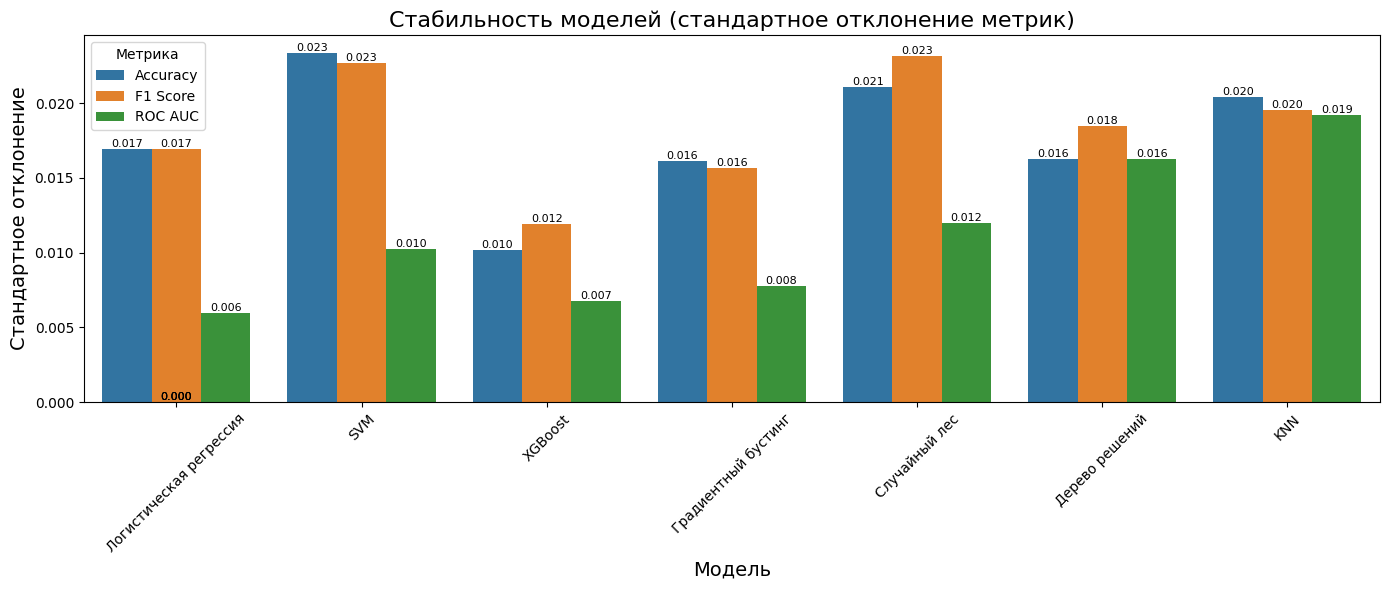

In [ ]:
# Визуализация стабильности моделей (стандартное отклонение метрик)
plt.figure(figsize=(14, 6))

# Создаем данные для графика стабильности
stability_data = []
for name, res in results.items():
    stability_data.append({
        'Модель': name,
        'Метрика': 'Accuracy',
        'Стандартное отклонение': res['accuracy_std']
    })
    stability_data.append({
        'Модель': name,
        'Метрика': 'F1 Score',
        'Стандартное отклонение': res['f1_std']
    })
    if 'roc_auc_std' in res:
        stability_data.append({
            'Модель': name,
            'Метрика': 'ROC AUC',
            'Стандартное отклонение': res['roc_auc_std']
        })

stability_df = pd.DataFrame(stability_data)

# Сортируем модели в том же порядке, что и в предыдущем графике
model_order = cv_results_numeric_sorted['Модель'].tolist()
stability_df['Модель'] = pd.Categorical(stability_df['Модель'], categories=model_order, ordered=True)
stability_df = stability_df.sort_values('Модель')

# Рисуем график стабильности
sns.barplot(data=stability_df, x='Модель', y='Стандартное отклонение', hue='Метрика')
plt.title('Стабильность моделей (стандартное отклонение метрик)', fontsize=16)
plt.xlabel('Модель', fontsize=14)
plt.ylabel('Стандартное отклонение', fontsize=14)
plt.xticks(rotation=45)

# Добавляем значения над столбцами
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_height():.3f}",
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center', va = 'bottom',
                      fontsize=8)

plt.tight_layout()
plt.show()

## 4. Реализация собственной логистической регрессии

In [ ]:
class CustomLogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000, random_state=None):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.random_state = random_state
        self.weights = None
        self.bias = None

    def _sigmoid(self, z):
        """Функция сигмоиды для преобразования значения в вероятность"""
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        """Обучение модели логистической регрессии"""
        # Инициализация генератора случайных чисел
        if self.random_state is not None:
            np.random.seed(self.random_state)

        # Получение размеров входных данных
        n_samples, n_features = X.shape

        # Инициализация весов и смещения
        self.weights = np.random.randn(n_features) * 0.01
        self.bias = 0

        # Градиентный спуск
        for _ in range(self.num_iterations):
            # Вычисление линейной комбинации
            linear_model = np.dot(X, self.weights) + self.bias

            # Применение функции активации
            y_pred = self._sigmoid(linear_model)

            # Вычисление градиентов
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y))
            db = (1/n_samples) * np.sum(y_pred - y)

            # Обновление параметров
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

        return self

    def predict_proba(self, X):
        """Предсказание вероятностей классов"""
        linear_model = np.dot(X, self.weights) + self.bias
        probabilities = self._sigmoid(linear_model)
        return np.vstack((1-probabilities, probabilities)).T

    def predict(self, X):
        """Предсказание классов: если вероятность > 0.5, то 1, иначе 0"""
        probabilities = self.predict_proba(X)[:, 1]
        return (probabilities >= 0.5).astype(int)

### 4.1. Сравнение стандартной и собственной логистической регрессии


=== Собственная логистическая регрессия ===
Accuracy: 0.891 ± 0.019
F1-score: 0.891 ± 0.020
ROC-AUC: 0.966 ± 0.005


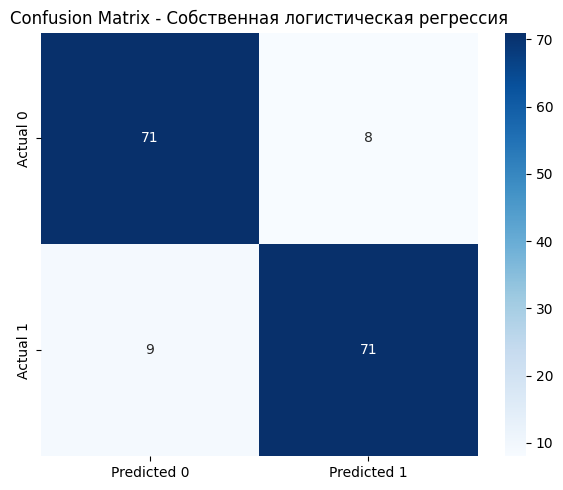

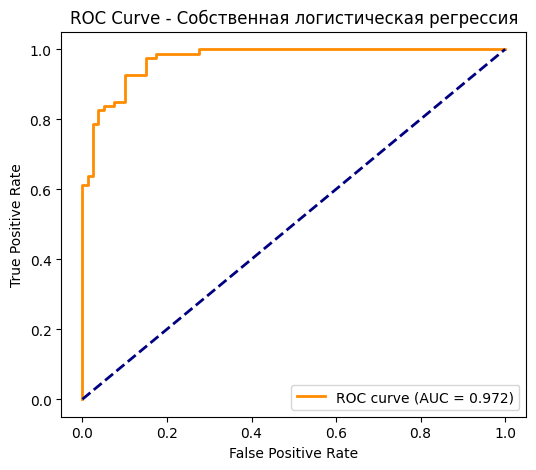


=== Стандартная логистическая регрессия ===
Accuracy: 0.892 ± 0.017
F1-score: 0.892 ± 0.017
ROC-AUC: 0.966 ± 0.006


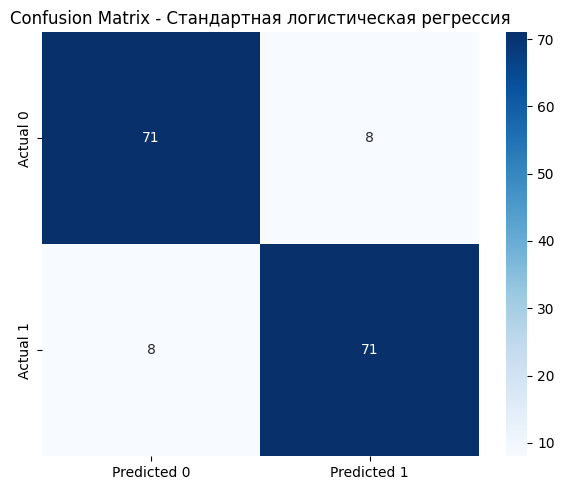

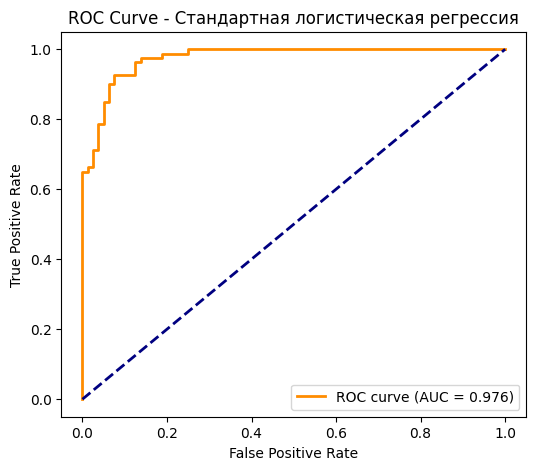


Сводная таблица результатов:


,Model,Accuracy,F1 Score,ROC AUC
0,Стандартная логистическая регрессия,0.892 ± 0.017,0.892 ± 0.017,0.966 ± 0.006
1,Собственная логистическая регрессия,0.891 ± 0.019,0.891 ± 0.020,0.966 ± 0.005


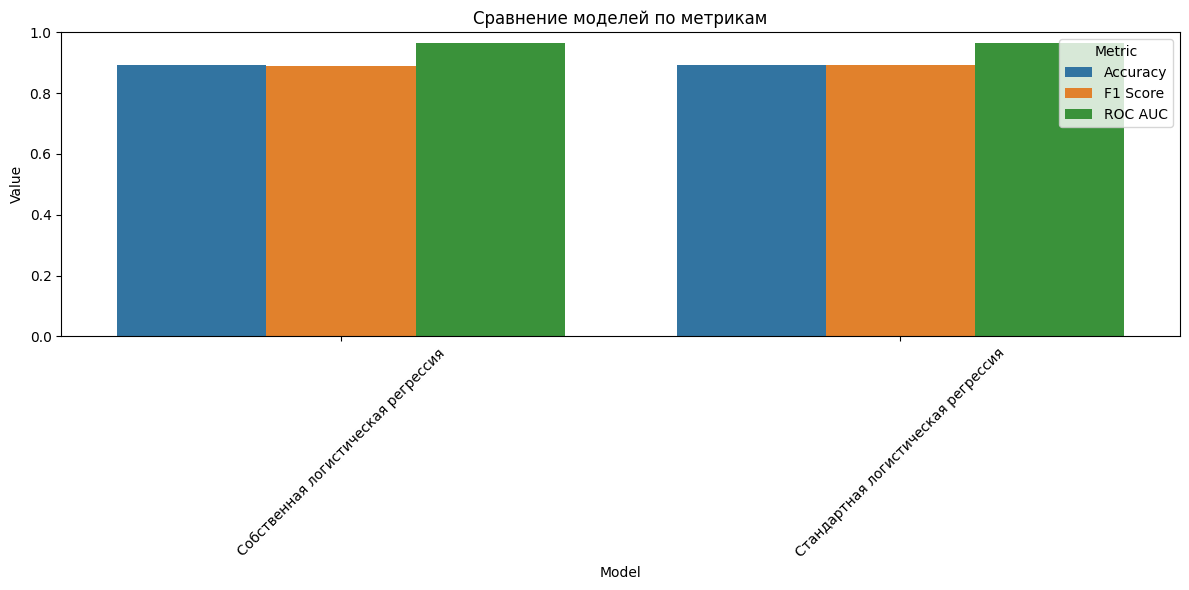

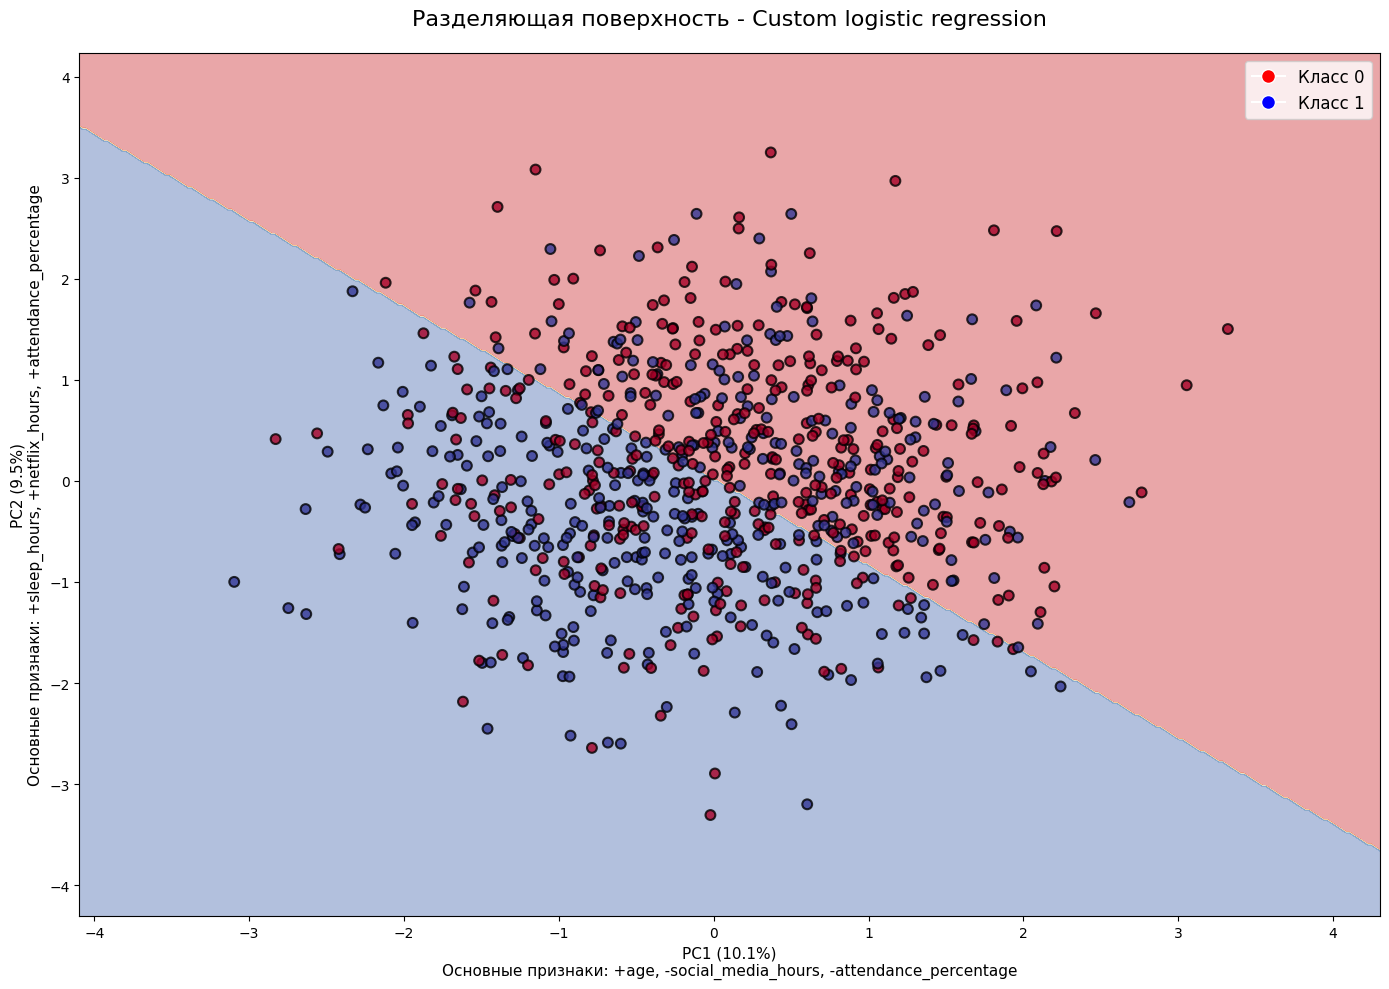


ВКЛАД ПРИЗНАКОВ В ГЛАВНЫЕ КОМПОНЕНТЫ

PC1 (первая главная компонента):
  1. age                            : +0.534
  2. social_media_hours             : -0.512
  3. attendance_percentage          : -0.510
  4. study_hours_per_day            : -0.260
  5. exercise_frequency             : +0.206

PC2 (вторая главная компонента):
  1. sleep_hours                    : +0.490
  2. netflix_hours                  : +0.452
  3. attendance_percentage          : +0.437
  4. exercise_frequency             : +0.374
  5. mental_health_rating           : -0.352


⚠️  У вас 25 признаков - это слишком много для попарной визуализации.
Использую PCA для уменьшения до 6 главных компонент.

Совет: Для визуализации реальных признаков (не PCA) используйте
       функцию с меньшим количеством признаков или выберите
       топ-8 наиболее важных признаков по feature importance.

Топ-3 признака для каждой компоненты:
  PC1: age(+0.53), social_media_hours(-0.51), attendance_percentage(-0.51)
  PC2: sleep_hours

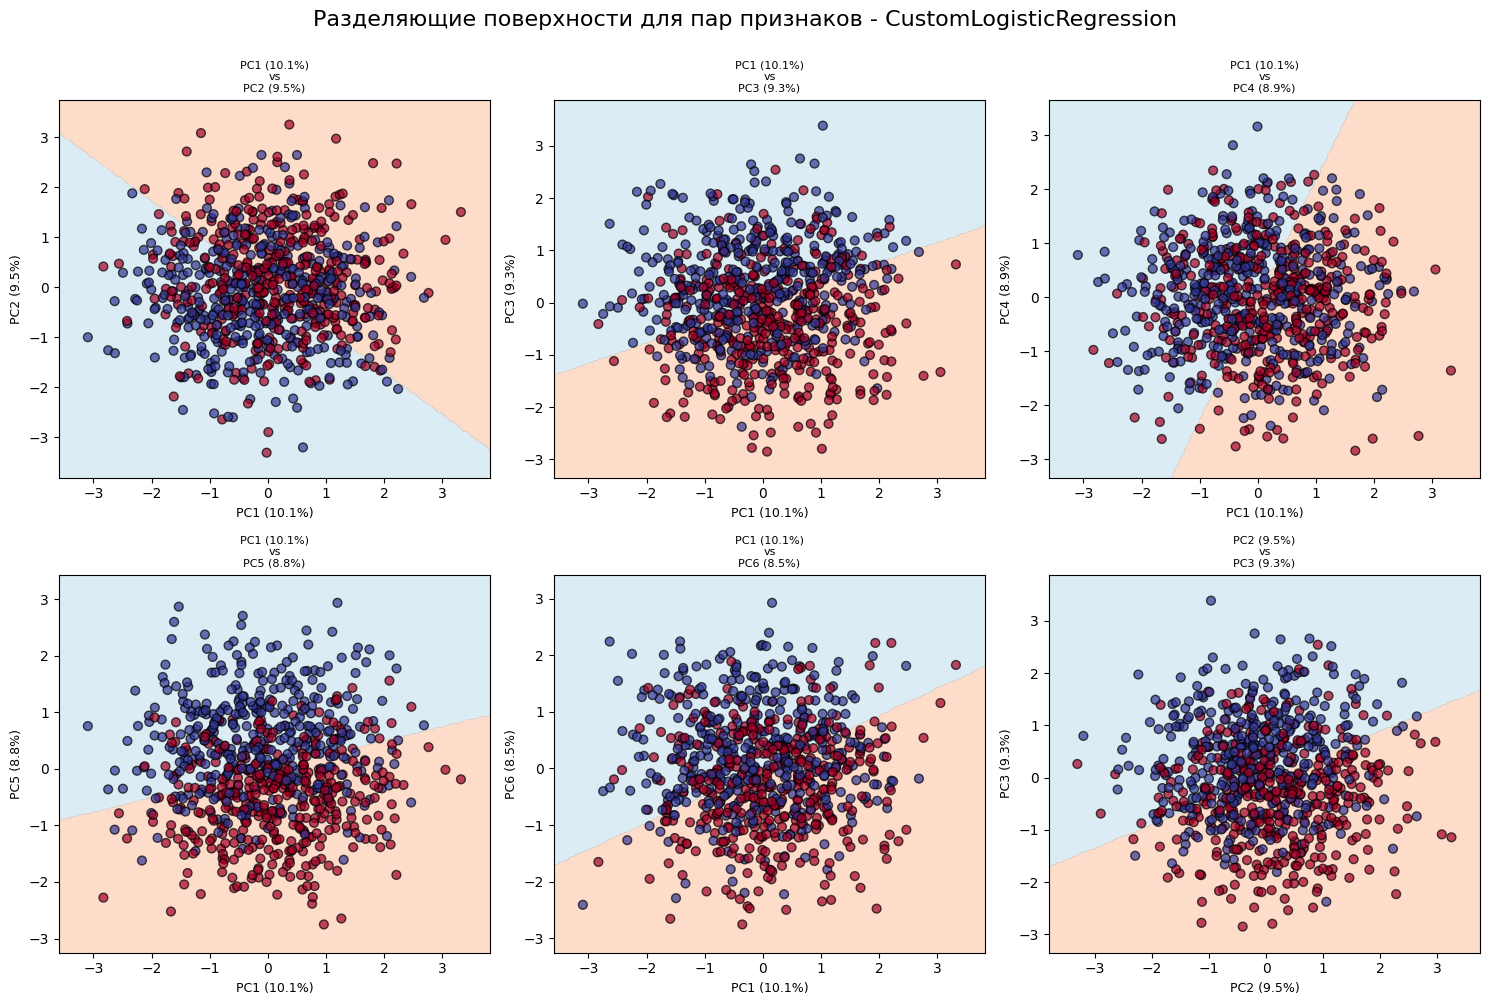

In [ ]:
# После реализации собственной логистической регрессии
# Создаем словарь, включающий собственную реализацию
custom_model = CustomLogisticRegression(learning_rate=0.01, num_iterations=1000, random_state=RANDOM_STATE)

models_with_custom = {
    "Собственная логистическая регрессия": custom_model,
    "Стандартная логистическая регрессия": LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
}

# Запускаем сравнение с включением собственной реализации
custom_results = test_models_pipeline(X_array, y_array, models_with_custom, n_splits=5)

plot_decision_surface_2d(X_train_processed, y_train_binary, custom_model, 'Custom logistic regression', feature_names=all_features)

# Визуализация пар признаков:
plot_decision_surface_pairwise(X_train_processed, y_train_binary, custom_model,
                               feature_names=all_features, n_pairs=6)

## 5. Подбор гиперпараметров с помощью Optuna


In [ ]:
!pip install optuna

[I 2025-10-23 17:34:46,377] A new study created in memory with name: no-name-5ab317a3-5e04-4341-a029-5b0aabc8a131
[I 2025-10-23 17:34:47,333] Trial 0 finished with value: 0.8574999999999999 and parameters: {'n_estimators': 80, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8574999999999999.
[I 2025-10-23 17:34:49,347] Trial 1 finished with value: 0.86 and parameters: {'n_estimators': 180, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.86.
[I 2025-10-23 17:34:51,809] Trial 2 finished with value: 0.85375 and parameters: {'n_estimators': 220, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.86.
[I 2025-10-23 17:34:54,494] Trial 3 finished with value: 0.85125 and parameters: {'n_estimators': 190, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.86.
[I 2025-10-23 17:34:58,125] Trial 4 finished with value: 

Лучшие гиперпараметры:
{'n_estimators': 140, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 4}
Лучшая точность (accuracy): 0.8638

=== Оптимизированный случайный лес ===
Accuracy: 0.853 ± 0.025
F1-score: 0.854 ± 0.026
ROC-AUC: 0.942 ± 0.010


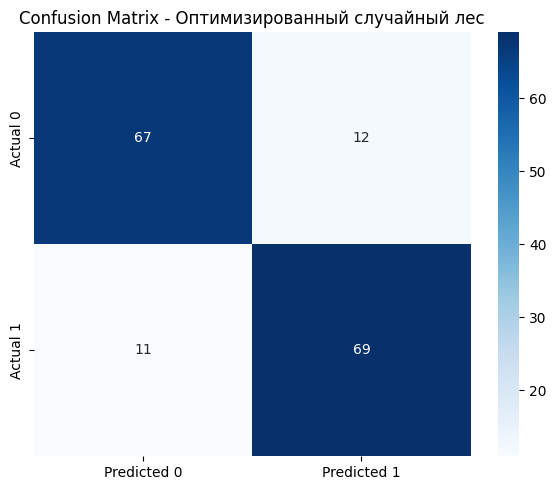

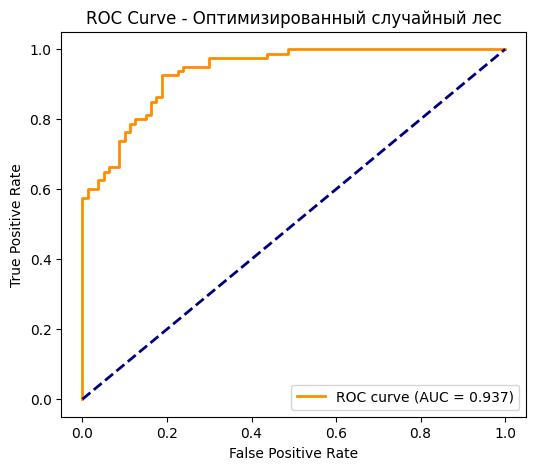


Сводная таблица результатов:


,Model,Accuracy,F1 Score,ROC AUC
0,Оптимизированный случайный лес,0.853 ± 0.025,0.854 ± 0.026,0.942 ± 0.010


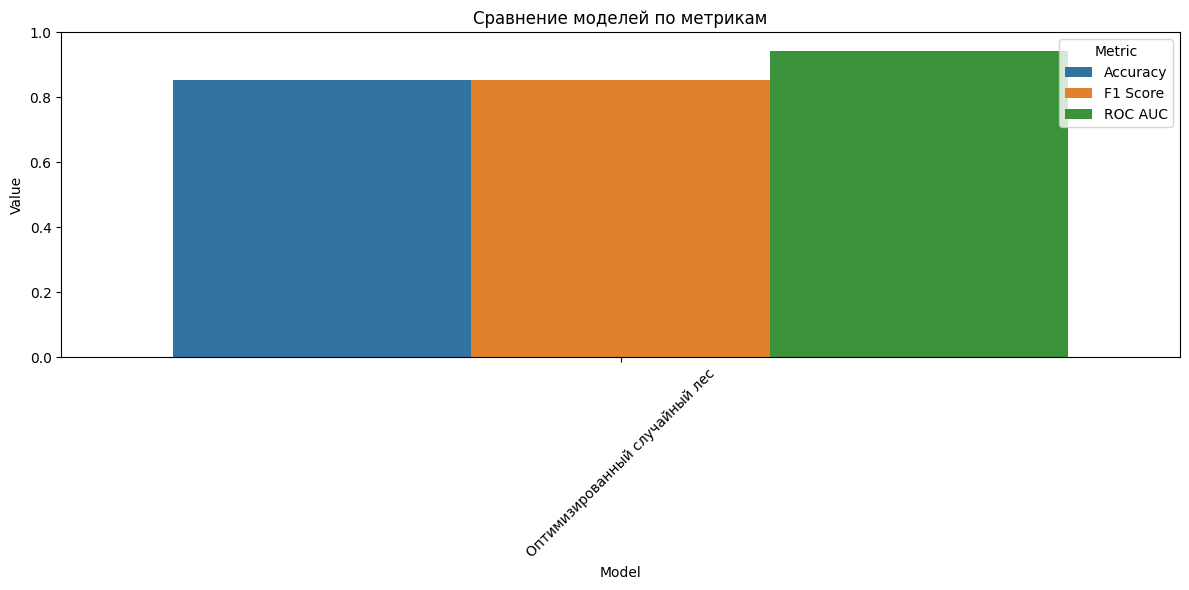

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score

# Функция объективной оценки для Random Forest
def objective_rf(trial):
    # Гиперпараметры для оптимизации
    n_estimators = trial.suggest_int('n_estimators', 50, 300, step=10)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=RANDOM_STATE
    )

    # Используем кросс-валидацию для оценки
    scores = cross_val_score(
        rf, X_train_processed, y_train_binary,
        cv=5, scoring='accuracy'
    )

    # Возвращаем среднее значение метрики
    return np.mean(scores)

# Создаем исследование
study = optuna.create_study(direction='maximize')
# Запускаем оптимизацию (20 итераций)
study.optimize(objective_rf, n_trials=20)

# Выводим лучшие параметры
print("Лучшие гиперпараметры:")
print(study.best_params)
print(f"Лучшая точность (accuracy): {study.best_value:.4f}")

# Создаем оптимизированную модель
optimized_rf = RandomForestClassifier(**study.best_params, random_state=RANDOM_STATE)

X_array = X_train_processed
y_array = np.array(y_train_binary) if hasattr(y_train_binary, 'values') else y_train_binary

models = {"Оптимизированный случайный лес": optimized_rf}

# Запускаем тестирование моделей
results = test_models_pipeline(X_array, y_array, models, n_splits=5)

🎓 КАЛЬКУЛЯТОР ПРЕДСКАЗАНИЯ УСПЕВАЕМОСТИ

Введите данные студента для предсказания успеваемости:

📊 Введите данные студента:
--------------------------------------------------
Возраст (17-24 лет): 19
Пол (Female/Male/Other): Male
Часы учёбы в день (0-8.3): 1
Часы в соцсетях в день (0-7.2): 5
Часы Netflix в день (0-5.4): 1
Работает на полставки? (Yes/No): No
Посещаемость % (56-100): 80
Часы сна в день (3.2-10): 7
Качество питания (Poor/Fair/Good): Fair
Частота упражнений (раз в неделю, 0-6): 4
Образование родителей (High School/Bachelor/Master) [или Enter для пропуска]: Master
Качество интернета (Poor/Average/Good): Good
Оценка ментального здоровья (1-10): 8
Участие во внеучебной деятельности (Yes/No): Yes

🎯 РЕЗУЛЬТАТЫ ПРЕДСКАЗАНИЯ

⚠️ ПРОГНОЗ: НИЗКАЯ УСПЕВАЕМОСТЬ
   📉 Ожидаемый экзаменационный балл: < 70 (из 100)
   🎯 Уверенность модели: 77.0%


/tmp/ipython-input-2304400563.py:188: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2304400563.py:188: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2304400563.py:188: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes

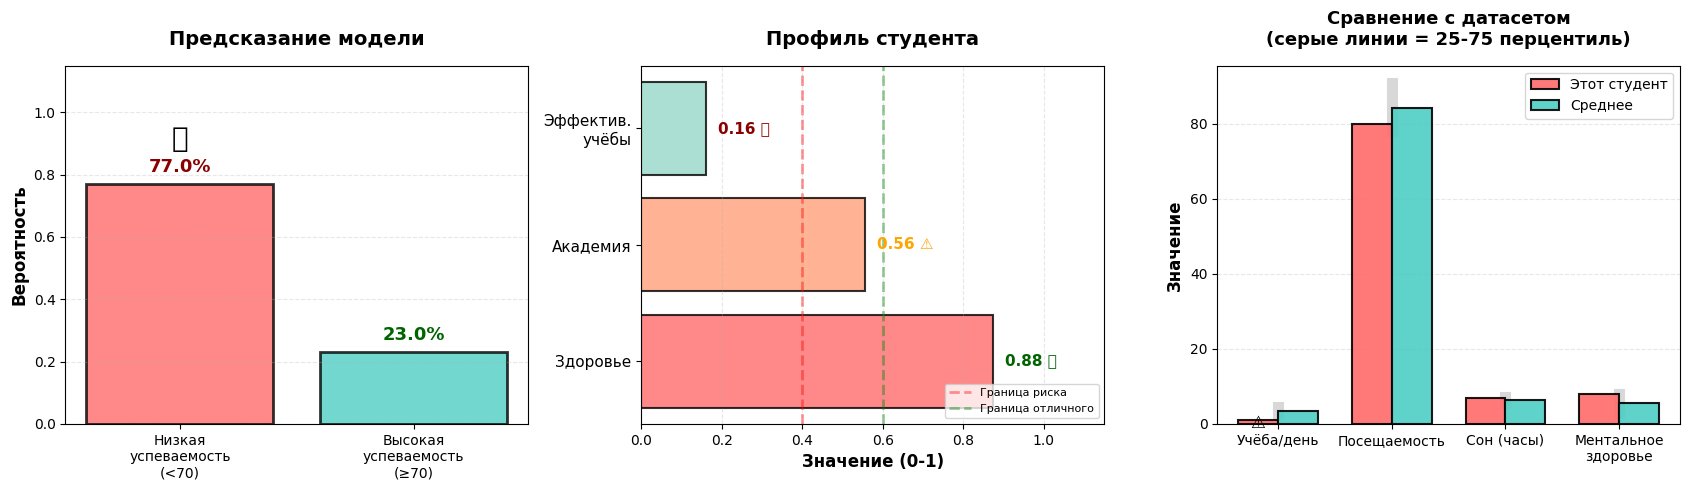


💡 ПЕРСОНАЛЬНЫЕ РЕКОМЕНДАЦИИ ДЛЯ УЛУЧШЕНИЯ УСПЕВАЕМОСТИ

🔴 КРИТИЧНО: Часы учёбы
   📊 Сейчас: 1.0 ч/день (ниже 25% студентов)
   🎯 Цель: 4-5 ч/день (75% перцентиль)
   💪 Эффект: +15-20% к баллу

🟡 Посещаемость: стремитесь к 90%+
   📊 Сейчас: 80% (ниже медианы)
   🎯 Цель: 90%+
   💪 Эффект: +10-15% к баллу

🟡 Соцсети: слишком много времени
   📊 Сейчас: 5.0 ч/день (выше 75% студентов)
   🎯 Цель: 2-3 ч/день (медиана)
   💪 Эффект: +5-10% к баллу

📊 ДЕТАЛЬНАЯ СТАТИСТИКА ПРОФИЛЯ

📚 Учёба: 1.0 ч/день - нижние 25% ⚠️
✋ Посещаемость: 80% - ниже среднего ⚠
😴 Сон: 7.0 ч/день - выше среднего ✓
📱 Соцсети: 5.0 ч/день - топ-25% 🌟 (обратная шкала)
🧠 Ментальное здоровье: 8/10 - топ-25% 🌟

📈 Индексы:
   • Индекс здоровья: 0.88/1.00 ✅
   • Академический индекс: 0.56/1.00 ⚠️
   • Эффективность учёбы: 0.80 ч/день
   • Баланс учёба/развлечения: 0.17

📚 Следуйте рекомендациям для достижения максимального результата!



In [ ]:
### 4. Практическое применение: Калькулятор успеваемости студента

print("="*70)
print("🎓 КАЛЬКУЛЯТОР ПРЕДСКАЗАНИЯ УСПЕВАЕМОСТИ")
print("="*70)
print("\nВведите данные студента для предсказания успеваемости:\n")

# Функция для интерактивного предсказания
def predict_student_performance():
    """
    Интерактивный калькулятор успеваемости студента.
    Предсказывает успеваемость и даёт рекомендации.
    """

    # Собираем данные от пользователя
    print("📊 Введите данные студента:")
    print("-" * 50)

    student_data = {
        'age': int(input("Возраст (17-24 лет): ")),
        'gender': input("Пол (Female/Male/Other): "),
        'study_hours_per_day': float(input("Часы учёбы в день (0-8.3): ")),
        'social_media_hours': float(input("Часы в соцсетях в день (0-7.2): ")),
        'netflix_hours': float(input("Часы Netflix в день (0-5.4): ")),
        'part_time_job': input("Работает на полставки? (Yes/No): "),
        'attendance_percentage': float(input("Посещаемость % (56-100): ")),
        'sleep_hours': float(input("Часы сна в день (3.2-10): ")),
        'diet_quality': input("Качество питания (Poor/Fair/Good): "),
        'exercise_frequency': int(input("Частота упражнений (раз в неделю, 0-6): ")),
        'parental_education_level': input("Образование родителей (High School/Bachelor/Master) [или Enter для пропуска]: ") or None,
        'internet_quality': input("Качество интернета (Poor/Average/Good): "),
        'mental_health_rating': int(input("Оценка ментального здоровья (1-10): ")),
        'extracurricular_participation': input("Участие во внеучебной деятельности (Yes/No): ")
    }

    # Создаём DataFrame
    import pandas as pd
    student_df = pd.DataFrame([student_data])

    # ВЫЧИСЛЯЕМ СОЗДАННЫЕ ПРИЗНАКИ
    student_df['health_index'] = (
        student_df['sleep_hours'] / 8 +
        student_df['mental_health_rating'] / 10 +
        (24 - student_df['social_media_hours']) / 20
    ) / 3

    student_df['academic_index'] = (
        student_df['study_hours_per_day'] / 5 +
        student_df['attendance_percentage'] / 100 +
        student_df['exercise_frequency'] / 6
    ) / 3

    student_df['study_leisure_ratio'] = student_df['study_hours_per_day'] / (student_df['social_media_hours'] + 1)
    student_df['effective_study'] = student_df['study_hours_per_day'] * (student_df['attendance_percentage'] / 100)
    student_df['study_squared'] = student_df['study_hours_per_day'] ** 2
    student_df['sleep_squared'] = student_df['sleep_hours'] ** 2
    student_df['sleep_social_interaction'] = student_df['sleep_hours'] * (24 - student_df['social_media_hours'])
    student_df['at_risk_student'] = ((student_df['sleep_hours'] < 6) & (student_df['social_media_hours'] > 4)).astype(int)

    # Предсказание
    X_student = preprocessor.transform(student_df)
    prediction = best_model.predict(X_student)[0]
    probability = best_model.predict_proba(X_student)[0]

    # Красивый вывод результатов
    print("\n" + "="*70)
    print("🎯 РЕЗУЛЬТАТЫ ПРЕДСКАЗАНИЯ")
    print("="*70)

    if prediction == 1:
        print("\n✅ ПРОГНОЗ: ВЫСОКАЯ УСПЕВАЕМОСТЬ")
        print(f"   📈 Ожидаемый экзаменационный балл: >= 70 (из 100)")
        print(f"   🎯 Уверенность модели: {probability[1]*100:.1f}%")
        emoji = "🎉"
        status_color = "🟢"
    else:
        print("\n⚠️ ПРОГНОЗ: НИЗКАЯ УСПЕВАЕМОСТЬ")
        print(f"   📉 Ожидаемый экзаменационный балл: < 70 (из 100)")
        print(f"   🎯 Уверенность модели: {probability[0]*100:.1f}%")
        emoji = "📚"
        status_color = "🔴"

    # Визуализация
    import matplotlib.pyplot as plt
    import numpy as np

    fig, axes = plt.subplots(1, 3, figsize=(17, 5))

    # График 1: Вероятность
    colors_prob = ['#FF6B6B', '#4ECDC4']
    bars = axes[0].bar(['Низкая\nуспеваемость\n(<70)', 'Высокая\nуспеваемость\n(≥70)'],
                probability, color=colors_prob, alpha=0.8, edgecolor='black', linewidth=2)
    axes[0].set_ylabel('Вероятность', fontsize=12, fontweight='bold')
    axes[0].set_title('Предсказание модели', fontsize=14, fontweight='bold', pad=15)
    axes[0].set_ylim(0, 1.15)
    axes[0].grid(axis='y', alpha=0.3, linestyle='--')

    for i, v in enumerate(probability):
        axes[0].text(i, v + 0.04, f'{v*100:.1f}%', ha='center',
                    fontweight='bold', fontsize=13,
                    color='darkred' if i == 0 else 'darkgreen')

    # Добавляем звёздочку для предсказанного класса
    predicted_idx = 1 if prediction == 1 else 0
    axes[0].text(predicted_idx, probability[predicted_idx] + 0.12, '⭐',
                ha='center', fontsize=20)

    # График 2: Индексы студента с зонами
    indices = {
        'Здоровье': student_df['health_index'].values[0],
        'Академия': student_df['academic_index'].values[0],
        'Эффектив.\nучёбы': min(student_df['effective_study'].values[0] / 5, 1.0)  # нормализуем
    }

    colors_bars = ['#FF6B6B', '#FFA07A', '#98D8C8']
    y_pos = np.arange(len(indices))

    bars = axes[1].barh(y_pos, list(indices.values()), color=colors_bars,
                       alpha=0.8, edgecolor='black', linewidth=1.5)

    # Добавляем зоны (плохо/средне/хорошо)
    axes[1].axvline(x=0.4, color='red', linestyle='--', alpha=0.4, linewidth=2, label='Граница риска')
    axes[1].axvline(x=0.6, color='green', linestyle='--', alpha=0.4, linewidth=2, label='Граница отличного')

    axes[1].set_yticks(y_pos)
    axes[1].set_yticklabels(list(indices.keys()), fontsize=11)
    axes[1].set_xlabel('Значение (0-1)', fontsize=12, fontweight='bold')
    axes[1].set_title('Профиль студента', fontsize=14, fontweight='bold', pad=15)
    axes[1].set_xlim(0, 1.15)
    axes[1].grid(axis='x', alpha=0.3, linestyle='--')
    axes[1].legend(loc='lower right', fontsize=8)

    # Добавляем значения и оценку
    for i, (k, v) in enumerate(indices.items()):
        if v > 0.6:
            status = '✅'
            color = 'darkgreen'
        elif v > 0.4:
            status = '⚠️'
            color = 'orange'
        else:
            status = '❌'
            color = 'darkred'

        axes[1].text(v + 0.03, i, f'{v:.2f} {status}', va='center',
                    fontweight='bold', fontsize=11, color=color)

    # График 3: Сравнение со средними (с процентилями)
    stats_data = {
        'Учёба/день': (student_df['study_hours_per_day'].values[0], 3.55, 2.6, 4.5),
        'Посещаемость': (student_df['attendance_percentage'].values[0], 84.13, 78.0, 91.0),
        'Сон (часы)': (student_df['sleep_hours'].values[0], 6.47, 5.6, 7.3),
        'Ментальное\nздоровье': (student_df['mental_health_rating'].values[0], 5.44, 3.0, 8.0)
    }

    x_pos = np.arange(len(stats_data))
    student_vals = [v[0] for v in stats_data.values()]
    mean_vals = [v[1] for v in stats_data.values()]
    q25_vals = [v[2] for v in stats_data.values()]
    q75_vals = [v[3] for v in stats_data.values()]

    width = 0.35

    # Рисуем диапазон 25-75 перцентиль
    for i, (q25, q75) in enumerate(zip(q25_vals, q75_vals)):
        axes[2].plot([i, i], [q25, q75], color='gray', linewidth=8, alpha=0.3, zorder=1)

    bars1 = axes[2].bar(x_pos - width/2, student_vals, width, label='Этот студент',
                       color='#FF6B6B', alpha=0.9, edgecolor='black', linewidth=1.5, zorder=3)
    bars2 = axes[2].bar(x_pos + width/2, mean_vals, width, label='Среднее',
                       color='#4ECDC4', alpha=0.9, edgecolor='black', linewidth=1.5, zorder=3)

    # Добавляем звёздочки для выдающихся значений
    for i, val in enumerate(student_vals):
        if val > q75_vals[i]:
            axes[2].text(i - width/2, val + 1, '⭐', ha='center', fontsize=14)
        elif val < q25_vals[i]:
            axes[2].text(i - width/2, val - 2, '⚠️', ha='center', fontsize=12)

    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(stats_data.keys(), fontsize=10)
    axes[2].set_ylabel('Значение', fontsize=12, fontweight='bold')
    axes[2].set_title('Сравнение с датасетом\n(серые линии = 25-75 перцентиль)',
                     fontsize=13, fontweight='bold', pad=15)
    axes[2].legend(fontsize=10, loc='upper right')
    axes[2].grid(axis='y', alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.show()

    # Рекомендации с учётом статистики датасета
    print("\n" + "="*70)
    print("💡 ПЕРСОНАЛЬНЫЕ РЕКОМЕНДАЦИИ ДЛЯ УЛУЧШЕНИЯ УСПЕВАЕМОСТИ")
    print("="*70 + "\n")

    recommendations = []

    # Анализ учёбы (медиана = 3.5, Q3 = 4.5)
    study = student_df['study_hours_per_day'].values[0]
    if study < 2.6:  # Q1
        recommendations.append("КРИТИЧНО: Часы учёбы")
        recommendations.append(f"    Сейчас: {study:.1f} ч/день (ниже 25% студентов)")
        recommendations.append(f"    Цель: 4-5 ч/день (75% перцентиль)")
        recommendations.append(f"    Эффект: +15-20% к баллу\n")
    elif study < 3.5:  # медиана
        recommendations.append(" Часы учёбы: можно улучшить")
        recommendations.append(f"    Сейчас: {study:.1f} ч/день (ниже медианы)")
        recommendations.append(f"    Цель: 4-5 ч/день")
        recommendations.append(f"    Эффект: +8-12% к баллу\n")

    # Анализ посещаемости (медиана = 84.4, Q3 = 91)
    attend = student_df['attendance_percentage'].values[0]
    if attend < 78:  # Q1
        recommendations.append(" КРИТИЧНО: Посещаемость")
        recommendations.append(f"   📊 Сейчас: {attend:.0f}% (ниже 25% студентов)")
        recommendations.append(f"   🎯 Цель: 90%+ (топ-25%)")
        recommendations.append(f"   💪 Эффект: +20-25% к баллу\n")
    elif attend < 84:  # медиана
        recommendations.append(" Посещаемость: стремитесь к 90%+")
        recommendations.append(f"   Сейчас: {attend:.0f}% (ниже медианы)")
        recommendations.append(f"    Цель: 90%+")
        recommendations.append(f"    Эффект: +10-15% к баллу\n")

    # Анализ сна (медиана = 6.5, Q3 = 7.3)
    sleep = student_df['sleep_hours'].values[0]
    if sleep < 5.6:  # Q1
        recommendations.append(" Сон: критически мало")
        recommendations.append(f"   Сейчас: {sleep:.1f} ч/день (ниже 25% студентов)")
        recommendations.append(f"    Цель: 7-8 ч/день")
        recommendations.append(f"    Эффект: +5-10% к баллу\n")

    # Анализ соцсетей (медиана = 2.5, Q3 = 3.3)
    social = student_df['social_media_hours'].values[0]
    if social > 3.3:  # Q3
        recommendations.append("🟡 Соцсети: слишком много времени")
        recommendations.append(f"    Сейчас: {social:.1f} ч/день (выше 75% студентов)")
        recommendations.append(f"    Цель: 2-3 ч/день (медиана)")
        recommendations.append(f"    Эффект: +5-10% к баллу\n")

    # Анализ ментального здоровья (медиана = 5, Q3 = 8)
    mental = student_df['mental_health_rating'].values[0]
    if mental < 3:  # Q1
        recommendations.append(" ВАЖНО: Ментальное здоровье")
        recommendations.append(f"    Сейчас: {mental}/10 (ниже 25% студентов)")
        recommendations.append(f"    Рекомендация: консультация психолога")
        recommendations.append(f"    Эффект: +10-15% к баллу\n")

    # Группа риска
    if student_df['at_risk_student'].values[0] == 1:
        recommendations.insert(0, " ВНИМАНИЕ: ВЫ В ГРУППЕ РИСКА ")
        recommendations.insert(1, f"    Мало сна ({sleep:.1f}ч) + много соцсетей ({social:.1f}ч)")
        recommendations.insert(2, "   Срочно скорректируйте режим дня!\n")

    if not recommendations:
        recommendations.append("ОТЛИЧНЫЕ ПОКАЗАТЕЛИ!")
        recommendations.append("    Вы в топ-20% студентов")
        recommendations.append("    Продолжайте в том же духе!\n")

    for rec in recommendations:
        print(rec)

    # Дополнительная статистика
    print("="*70)
    print("📊 ДЕТАЛЬНАЯ СТАТИСТИКА ПРОФИЛЯ")
    print("="*70)

    def get_percentile_status(value, q1, median, q3):
        if value >= q3:
            return "топ-25%"
        elif value >= median:
            return "выше среднего"
        elif value >= q1:
            return "ниже среднего"
        else:
            return "нижние 25%"

    print(f"\n📚 Учёба: {study:.1f} ч/день - {get_percentile_status(study, 2.6, 3.5, 4.5)}")
    print(f"Посещаемость: {attend:.0f}% - {get_percentile_status(attend, 78, 84.4, 91)}")
    print(f"Сон: {sleep:.1f} ч/день - {get_percentile_status(sleep, 5.6, 6.5, 7.3)}")
    print(f"Соцсети: {social:.1f} ч/день - {get_percentile_status(social, 1.7, 2.5, 3.3)} (обратная шкала)")
    print(f"Ментальное здоровье: {mental}/10 - {get_percentile_status(mental, 3, 5, 8)}")

    print(f"\n📈 Индексы:")
    print(f"   • Индекс здоровья: {student_df['health_index'].values[0]:.2f}/1.00 {'✅' if student_df['health_index'].values[0] > 0.6 else '⚠️' if student_df['health_index'].values[0] > 0.4 else '❌'}")
    print(f"   • Академический индекс: {student_df['academic_index'].values[0]:.2f}/1.00 {'✅' if student_df['academic_index'].values[0] > 0.6 else '⚠️' if student_df['academic_index'].values[0] > 0.4 else '❌'}")
    print(f"   • Эффективность учёбы: {student_df['effective_study'].values[0]:.2f} ч/день")
    print(f"   • Баланс учёба/развлечения: {student_df['study_leisure_ratio'].values[0]:.2f}")

    print(f"\n{emoji} Следуйте рекомендациям для достижения максимального результата!")
    print("="*70 + "\n")

    return student_df, prediction, probability

# Обучаем лучшую модель (если ещё не обучена)
if 'best_model' not in dir():
    best_model = log_reg
    best_model.fit(X_train_processed, y_train_binary)
    print("✅ Модель обучена и готова к работе!\n")

# ЗАПУСКАЕМ КАЛЬКУЛЯТОР
student_profile, pred, prob = predict_student_performance()


## 5. Вопросы

**1. Классификация писем: спам или не спам**

**Вопрос:**
У нас есть набор писем, для каждого известны признаки:

* количество восклицательных знаков,
* доля заглавных букв,
* наличие слов вроде “free”, “win”, “discount”,
* длина письма,
* наличие ссылок.

Задача — определить, является ли письмо **спамом** или **нормальным**.

**Распределение данных:**

* Данные нелинейно разделимы, но умеренно шумные.
* Классы примерно сбалансированы (50/50).

**Ответ:**

- **Модель:**

```
Gradient Boosting (GradientBoostingClassifier) или Random Forest
```

- **Почему:**

```
Данные нелинейно разделимы, значит простая линейная модель не подойдет. Нужно что-то, что умеет находить сложные зависимости между признаками.

Gradient Boosting хорош тут потому что:

- Отлично работает с нелинейными паттернами типа "если много восклицательных - знаков И есть слово 'free', то спам"
- Устойчив к шуму в данных
- Классы сбалансированы, так что проблем с дисбалансом не будет
- Признаки разнородные (числовые и категориальные), это не проблема для деревьев

Random Forest как альтернатива:

- Тоже нелинейный, тоже устойчив к шуму
- Проще настраивать, меньше гиперпараметров
- Покажет важность признаков, можно будет понять какие слова важнее

Логистическая регрессия слишком простая для таких данных, SVM можно, но медленнее работает, KNN не подходит из-за разномасштабных признаков.

Я бы начал с Random Forest, если результат не устроит - попробовал XGBoost.
```

**2. Прогноз сердечных заболеваний**

**Вопрос:**
Данные о пациентах:

* возраст, пол, давление, уровень холестерина, частота сердечных сокращений,
* наличие боли в груди и др.

Задача — определить, есть ли у человека сердечное заболевание.

**Распределение данных:**

* Классы умеренно сбалансированы (60/40).
* Признаки имеют нелинейные зависимости.

**Ответ:**

- **Модель:**

```
Gradient Boosting (XGBoost/LightGBM) или Random Forest
```

- **Почему:**

```
Тут ключевой момент - нелинейные зависимости. В медицинских данных часто важны именно комбинации признаков: "если возраст больше 50 И давление высокое И холестерин повышен, то риск высокий". Деревья решений это ловят хорошо.
Дисбаланс классов 60/40 не критичный, но можно подкрутить веса классов если понадобится.
В медицине важна интерпретируемость - врачам нужно понимать почему модель приняла такое решение. Random Forest дает feature importance, XGBoost можно дополнить SHAP values - это покажет вклад каждого признака для конкретного пациента.
XGBoost обычно дает лучшую точность, Random Forest чуть проще и стабильнее. Логистическая регрессия упустит взаимодействия между признаками, KNN медленный и чувствителен к выбросам.

Я бы выбрал XGBoost с последующим анализом через SHAP - и точность хорошая, и объяснить можно.
```

**3. Распознавание видов ирисов (Iris dataset)**

**Вопрос:**
По измерениям длины и ширины лепестков и чашелистиков нужно определить вид ириса:
`setosa`, `versicolor` или `virginica`.

**Распределение данных:**

* Данные чистые, малошумные.
* Классы хорошо разделяются в пространстве признаков.

**Ответ:**

- **Модель:**

```
Логистическая регрессия или KNN
```

- **Почему:**

```
Это классический учебный датасет с очень хорошими свойствами: всего 4 признака, классы хорошо разделяются, почти нет шума, один класс (setosa) вообще линейно отделяется от остальных.

Тут не нужны сложные модели. Логистическая регрессия справится отлично: простая и быстрая, идеально подходит для линейно/почти-линейно разделимых данных, можно посмотреть на коэффициенты и понять какие признаки важнее.

KNN тоже хорошо сработает: вообще не требует обучения, на маленьком датасете (150 образцов) будет быстрым, с k=3 или k=5 даст хороший результат.

Decision Tree можно использовать если нужно визуализировать логику принятия решений - это хорошо смотрится на презентации.

Random Forest или Gradient Boosting тут избыточны.

Я бы взял логистическую регрессию - просто, понятно, эффективно.
```

**4. Классификация отзывов о фильмах (положительный / отрицательный)**

**Вопрос:**
Для каждого отзыва по фильму дан текст. Нужно определить, положительный он или отрицательный.
Используются текстовые признаки — мешок слов (TF-IDF).

**Распределение данных:**

* Очень высокое число признаков (10k+ слов).
* Данные разреженные.

**Ответ:**

- **Модель:**

```
Логистическая регрессия с L1/L2 регуляризацией или Linear SVM
```

- **Почему:**

```
Текстовые данные имеют свою специфику: очень много признаков (10k+), данные разреженные - в каждом отзыве используется небольшая часть всех слов, TF-IDF уже дает хорошее представление данных.

Логистическая регрессия с регуляризацией:

L1 регуляризация автоматически отберет важные слова и отбросит лишние
L2 регуляризация уменьшит переобучение
Работает быстро на разреженных данных
Sklearn хорошо оптимизирован для таких задач

Linear SVM (LinearSVC): тоже хорошо работает с текстами, эффективен в высокоразмерных пространствах, можно ускорить через параметр dual=False.

Naive Bayes (MultinomialNB): классика для текстовой классификации,очень быстрый, хороший вариант для baseline.

Random Forest и Gradient Boosting не подходят - медленные на большом количестве признаков, много памяти жрут. KNN вообще не вариант - расстояния в 10k-мерном пространстве работают плохо. Обычный SVM с RBF ядром слишком медленный.

Я бы сделал так: Сначала MultinomialNB - быстрый baseline, потом логистическая регрессия с L2 - обычно точнее, если нужен максимум точности - Linear SVM с подбором параметра C.

Можно еще попробовать Voting Classifier, объединив несколько моделей - иногда дает прирост в пару процентов.
```
